In [159]:
import pandas as pd 
import numpy as np
from forex_python.converter import CurrencyRates
import re
import matplotlib.pyplot as plt
import random
import seaborn as sns
from datetime import datetime, timedelta
import time
import os
from models_func import *
import joblib
import importlib
from sklearn.neighbors import KNeighborsRegressor
import sklearn.tree as tree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import ElasticNet


import warnings
warnings.filterwarnings('ignore')



In [157]:
import models_func

In [158]:
importlib.reload(models_func)

<module 'models_func' from 'c:\\Users\\yarin\\Data Science - College Of Management\\Year 2\\Semester 2\\Data Science Fundementals\\Final Project\\DSF-final project\\Notebooks\\models_func.py'>

# Expedia cleaning


In [7]:
Expedia_hotels = pd.read_csv(r"C:\Users\yarin\Data Science - College Of Management\Year 2\Semester 2\Data Science Fundementals\Final Project\DSF-final project\Notebooks\expedia\Expedia_hotels.csv")

In [8]:
expedia_df = Expedia_hotels.copy()

In [9]:
expedia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Snapshot                45000 non-null  object 
 1   Index                   45000 non-null  int64  
 2   Hotel Name              45000 non-null  object 
 3   TTT                     45000 non-null  float64
 4   LOS                     45000 non-null  float64
 5   Grade                   44217 non-null  float64
 6   Num of Reviews          44217 non-null  object 
 7   Curr Price              45000 non-null  object 
 8   Original Price          20597 non-null  object 
 9   Percentage of discount  45000 non-null  float64
 10  Distance from center    45000 non-null  float64
 11  Type of room            45000 non-null  float64
 12  Location grade          45000 non-null  float64
 13  Is refundable           45000 non-null  bool   
 14  Late payment            45000 non-null

In [10]:
#taking only the date form the timestamp
expedia_df['Snapshot'] = expedia_df['Snapshot'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#keep the firt 100 hotels in each search
expedia_df = expedia_df.loc[expedia_df['Index'] < 100].reset_index(drop=True)

#increase the index in one to avoid the 0 index
expedia_df['Index'] = expedia_df['Index'] + 1

#convert from float to int
expedia_df['TTT'] = expedia_df['TTT'].astype('int64')
expedia_df['LOS'] = expedia_df['LOS'].astype('int64')

In [11]:
#we can see that we have 6 hotels with no grade, we can check if they have reviews
expedia_df.loc[pd.isnull(expedia_df['Grade'])]['Hotel Name'].value_counts()

The FIDI Hotel                           222
Latisha luxury place                     173
The Flat NYC                             120
Moxy Brooklyn Willamsburg                115
The Ritz-Carlton New York, NoMad         108
Latisha house                             28
Lovely 2 Bedroom In Brooklyn Sleeps 5     16
Untitled at 3 Freeman Alley                1
Name: Hotel Name, dtype: int64

In [12]:
#we see that the hotels without grade have no reviews
expedia_df.loc[pd.isnull(expedia_df['Num of Reviews'])]['Hotel Name'].value_counts()

The FIDI Hotel                           222
Latisha luxury place                     173
The Flat NYC                             120
Moxy Brooklyn Willamsburg                115
The Ritz-Carlton New York, NoMad         108
Latisha house                             28
Lovely 2 Bedroom In Brooklyn Sleeps 5     16
Untitled at 3 Freeman Alley                1
Name: Hotel Name, dtype: int64

In [13]:
#keep only the digits
expedia_df['Num of Reviews'] = expedia_df['Num of Reviews'].apply(lambda x: int(re.sub("[^0-9]", "", x)) if not pd.isnull(x) else x)


In [14]:
#check how much hotels have only one review, that can tell us if the hotels without reviews are likely to have zero reviews
expedia_df.loc[expedia_df['Num of Reviews'] == 1].shape

(38, 17)

In [15]:
expedia_df['Num of Reviews'] = expedia_df['Num of Reviews'].fillna(0)

In [16]:
expedia_df['Grade'].describe()

count    44217.000000
mean         8.410114
std          0.644215
min          5.600000
25%          8.000000
50%          8.600000
75%          8.800000
max         10.000000
Name: Grade, dtype: float64

(array([  170.,   127.,   735.,  1732.,  2791., 10976., 11705., 11122.,
         4204.,   655.]),
 array([ 5.6 ,  6.04,  6.48,  6.92,  7.36,  7.8 ,  8.24,  8.68,  9.12,
         9.56, 10.  ]),
 <BarContainer object of 10 artists>)

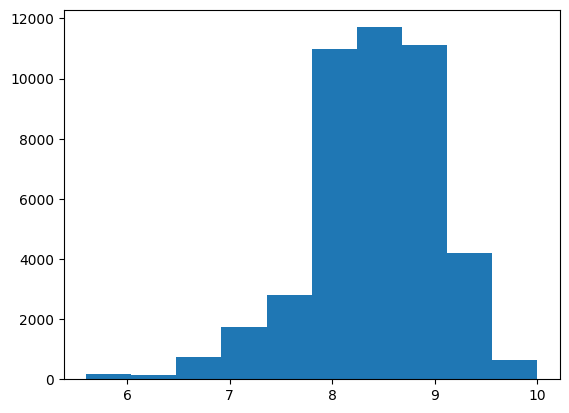

In [17]:
#lets see the histogram of the grades
plt.hist(expedia_df['Grade'])


In [18]:
#we choose to fill the missing values with a random number between 5 and 6 - whiche means that the hotel has a low grade
expedia_df['Grade'] = expedia_df['Grade'].fillna(round(random.uniform(5, 6),1))


In [19]:
expedia_df['Curr Price'] = expedia_df['Curr Price'].apply(lambda x: x.split('€')[1])

In [20]:
expedia_df['Original Price'] = expedia_df['Original Price'].apply(lambda x: x.split('€')[1] if not pd.isnull(x) else x)



In [21]:
expedia_df['Original Price']

0          360
1          NaN
2          493
3          NaN
4          NaN
         ...  
44995    2,352
44996    1,789
44997      NaN
44998      NaN
44999    1,583
Name: Original Price, Length: 45000, dtype: object

In [22]:
#fill the original price with the current price if it is missing
expedia_df['Original Price'] = expedia_df.apply(lambda x: x['Curr Price']  if pd.isnull(x['Original Price']) else x['Original Price'], axis = 1)
expedia_df['Original Price']

0          360
1          217
2          493
3          328
4          428
         ...  
44995    2,352
44996    1,789
44997    2,091
44998    1,816
44999    1,583
Name: Original Price, Length: 45000, dtype: object

In [23]:
#convert the prices to int
expedia_df['Original Price'] = expedia_df['Original Price'].apply(lambda x: int(x.replace(',','')))
expedia_df['Curr Price'] = expedia_df['Curr Price'].apply(lambda x: int(x.replace(',','')))

In [24]:
expedia_df['Original Price']  


0         360
1         217
2         493
3         328
4         428
         ... 
44995    2352
44996    1789
44997    2091
44998    1816
44999    1583
Name: Original Price, Length: 45000, dtype: int64

In [25]:
#create dictionary with the exchange rate for each date
c = CurrencyRates()
x = expedia_df['Snapshot'].unique()
curr_dict = {}
for date in x:
    curr_dict[date] = c.get_rate('EUR','USD', date) 

In [26]:
curr_dict[expedia_df['Snapshot'].loc[0]]

1.0929

In [27]:
expedia_df[['Original Price','Curr Price']]

Original Price  Curr Price
0                 360         278
1                 217         217
2                 493         449
3                 328         328
4                 428         428
...               ...         ...
44995            2352        1908
44996            1789        1373
44997            2091        2091
44998            1816        1816
44999            1583        1426

[45000 rows x 2 columns]

In [28]:
#multiply the prices by the exchange rate
expedia_df['Original Price'] = expedia_df.apply(lambda x: (x['Original Price']*curr_dict[x['Snapshot']])  , axis = 1)
expedia_df['Curr Price'] = expedia_df.apply(lambda x: (x['Curr Price']*curr_dict[x['Snapshot']])  , axis = 1)


In [29]:
expedia_df['Original Price'] = expedia_df['Original Price'].apply(lambda x: round(x,1))
expedia_df['Curr Price'] = expedia_df['Curr Price'].apply(lambda x: round(x,1))

In [30]:
expedia_df[['Original Price','Curr Price']]

Original Price  Curr Price
0               393.4       303.8
1               237.2       237.2
2               538.8       490.7
3               358.5       358.5
4               467.8       467.8
...               ...         ...
44995          2607.0      2114.8
44996          1982.9      1521.8
44997          2317.7      2317.7
44998          2012.9      2012.9
44999          1754.6      1580.6

[45000 rows x 2 columns]

In [31]:
#drop unrelevant columns
expedia_df.drop(['Percentage of discount', 'Distance from center', 'Type of room',
       'Location grade'], axis = 1, inplace=True)

In [32]:
#convert the columns to int

expedia_df[['Is refundable','Late payment', 'Option Member']] = expedia_df[['Is refundable','Late payment', 'Option Member']].astype('int64')


In [33]:
expedia_df['Extras included'] = expedia_df['Extras included'].apply(lambda x: 1 if not pd.isnull(x) else 0)


In [34]:
expedia_df['Percent of discount'] = expedia_df.apply(lambda x: 1 - (x['Curr Price']/x['Original Price'])  , axis = 1)
expedia_df['Percent of discount'] = expedia_df['Percent of discount'].apply(lambda x: round(x,2))

In [35]:
expedia_df =expedia_df[['Snapshot', 'Index', 'Hotel Name', 'TTT', 'LOS', 'Grade',
       'Num of Reviews', 'Curr Price', 'Original Price','Percent of discount', 'Is refundable',
       'Late payment', 'Extras included', 'Option Member']]

In [36]:
expedia_df.head(10)


Snapshot  Index                         Hotel Name  TTT  LOS  Grade  \
0  2022-03-06      1                        Hotel 32 32    1    1    8.0   
1  2022-03-06      2  Sonesta Simply Suites Jersey City    1    1    8.4   
2  2022-03-06      3                 Park Lane New York    1    1    8.8   
3  2022-03-06      4                       Arlo Midtown    1    1    9.2   
4  2022-03-06      5      PUBLIC, an Ian Schrager hotel    1    1    8.0   
5  2022-03-06      6           Hard Rock Hotel New York    1    1    9.2   
6  2022-03-06      7          Hotel Edison Times Square    1    1    7.8   
7  2022-03-06      8        YOTEL New York Times Square    1    1    7.0   
8  2022-03-06      9          Moxy Brooklyn Willamsburg    1    1    5.7   
9  2022-03-06     10          New York Marriott Marquis    1    1    9.0   

   Num of Reviews  Curr Price  Original Price  Percent of discount  \
0          1296.0       303.8           393.4                 0.23   
1          1002.0       237.2           237.2                 0.00   
2           305.0       490.7           538.8                 0.09   
3          3123.0       358.5           358.5                 0.00   
4          1465.0       467.8           467.8                 0.00   
5           716.0       592.4           592.4                 0.00   
6          2758.0       279.8           279.8                 0.00   
7          1889.0       240.4           262.3                 0.08   
8             0.0       264.5           264.5                 0.00   
9          1543.0       588.0           588.0                 0.00   

   Is refundable  Late payment  Extras included  Option Member  
0              0             0                0              0  
1              1             0                0              0  
2              0             0                0              0  
3              1             0                0              1  
4              0             0                0              1  
5              1             0                0              1  
6              1             0                1              1  
7              0             0                0              1  
8              0             0                0              0  
9              0             0                0              0

In [37]:
expedia_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Snapshot             45000 non-null  object 
 1   Index                45000 non-null  int64  
 2   Hotel Name           45000 non-null  object 
 3   TTT                  45000 non-null  int64  
 4   LOS                  45000 non-null  int64  
 5   Grade                45000 non-null  float64
 6   Num of Reviews       45000 non-null  float64
 7   Curr Price           45000 non-null  float64
 8   Original Price       45000 non-null  float64
 9   Percent of discount  45000 non-null  float64
 10  Is refundable        45000 non-null  int64  
 11  Late payment         45000 non-null  int64  
 12  Extras included      45000 non-null  int64  
 13  Option Member        45000 non-null  int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 4.8+ MB


# Expedia EDA

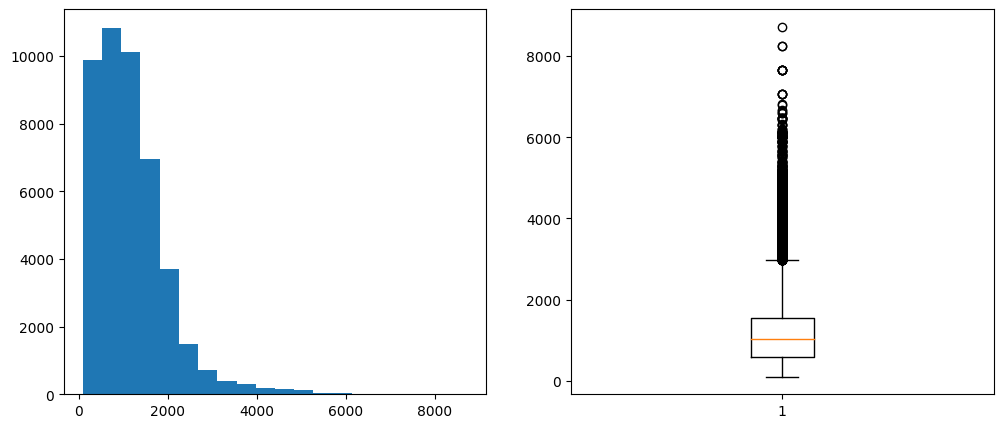

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(expedia_df['Curr Price'], bins=20)
ax2.boxplot(expedia_df['Curr Price'])
plt.show()

In [39]:
expedia_q1=expedia_df['Curr Price'].quantile(0.25)
expedia_q3=expedia_df['Curr Price'].quantile(0.75)

price_IQR = expedia_q3-expedia_q1

prices_lower_limit = expedia_q1 - (1.5 * price_IQR)
prices_upper_limit = expedia_q3 + (1.5 * price_IQR)

price_filter = expedia_df['Curr Price'].apply(lambda x: x > prices_lower_limit and x < prices_upper_limit)

expedia_df = expedia_df.loc[price_filter].reset_index(drop=True)


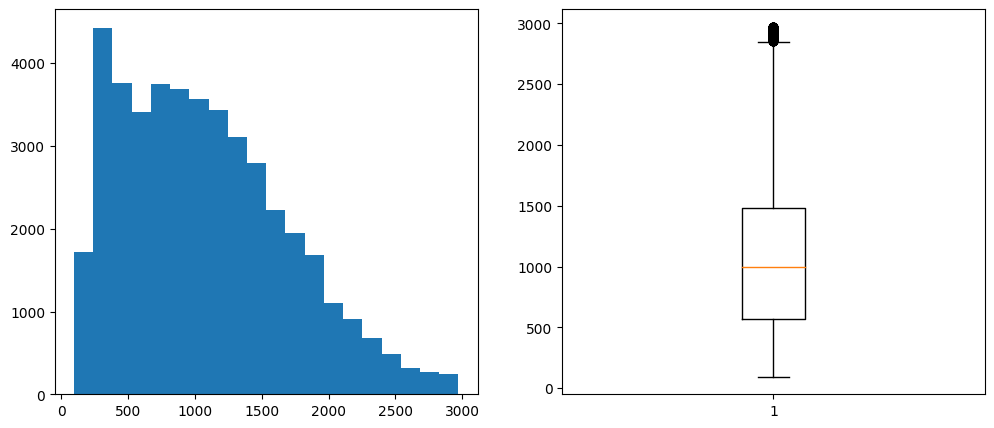

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(expedia_df['Curr Price'], bins=20)
ax2.boxplot(expedia_df['Curr Price'])
plt.show()

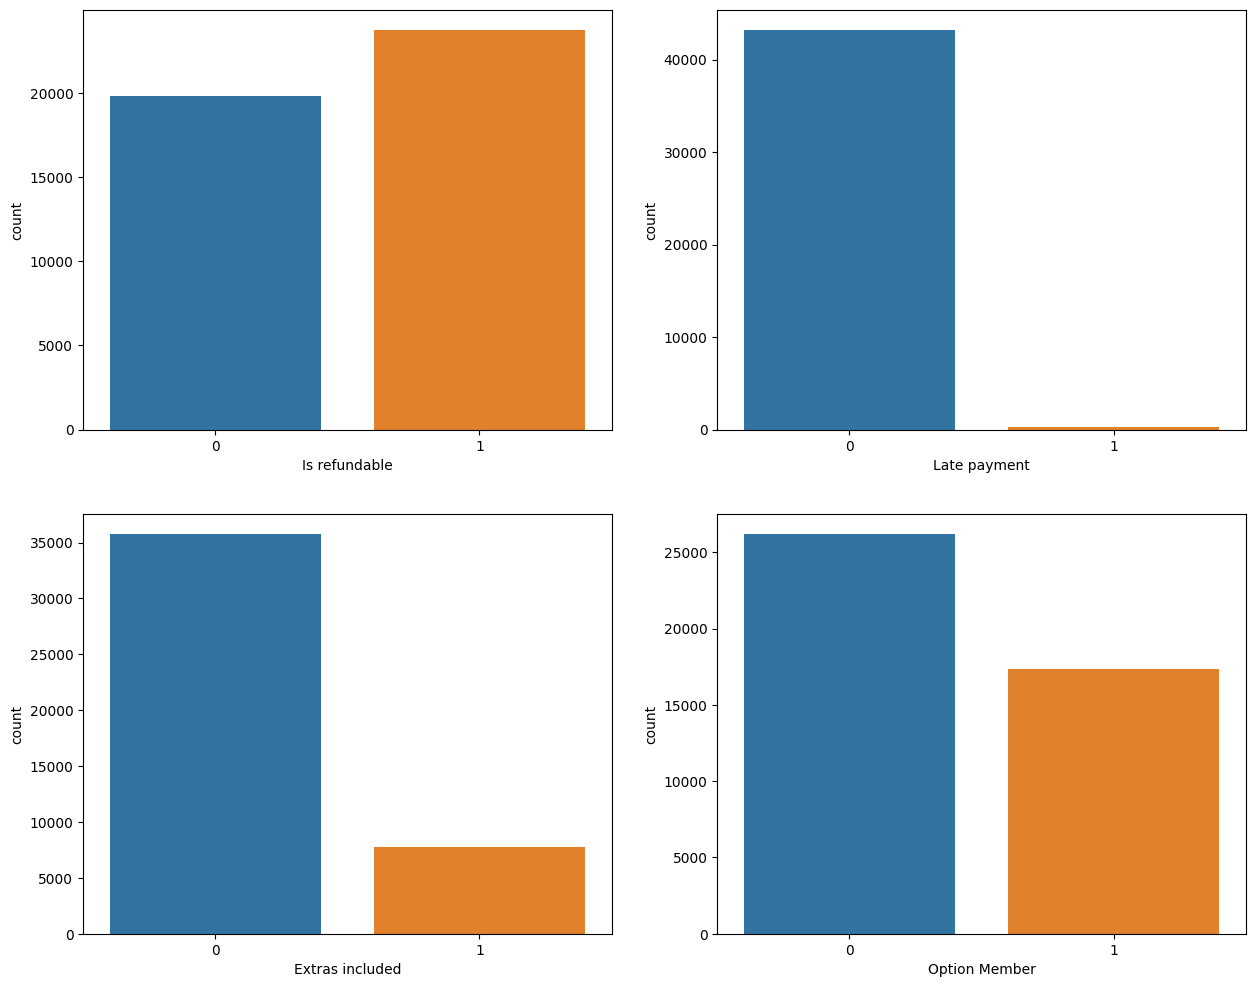

In [41]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
for col,ax in zip(expedia_df.columns[10:],axes.flatten()):
    sns.countplot(data=expedia_df,x=col,ax=ax)

ניתן לראות שכמות המלונות שמאפשרים תשלום מאוחר וכמות המלונות שיש להם אקסטרות היא קטנה ביחס לכמות המלונות ללא תשלום מאוחר וללא אקסטרות 

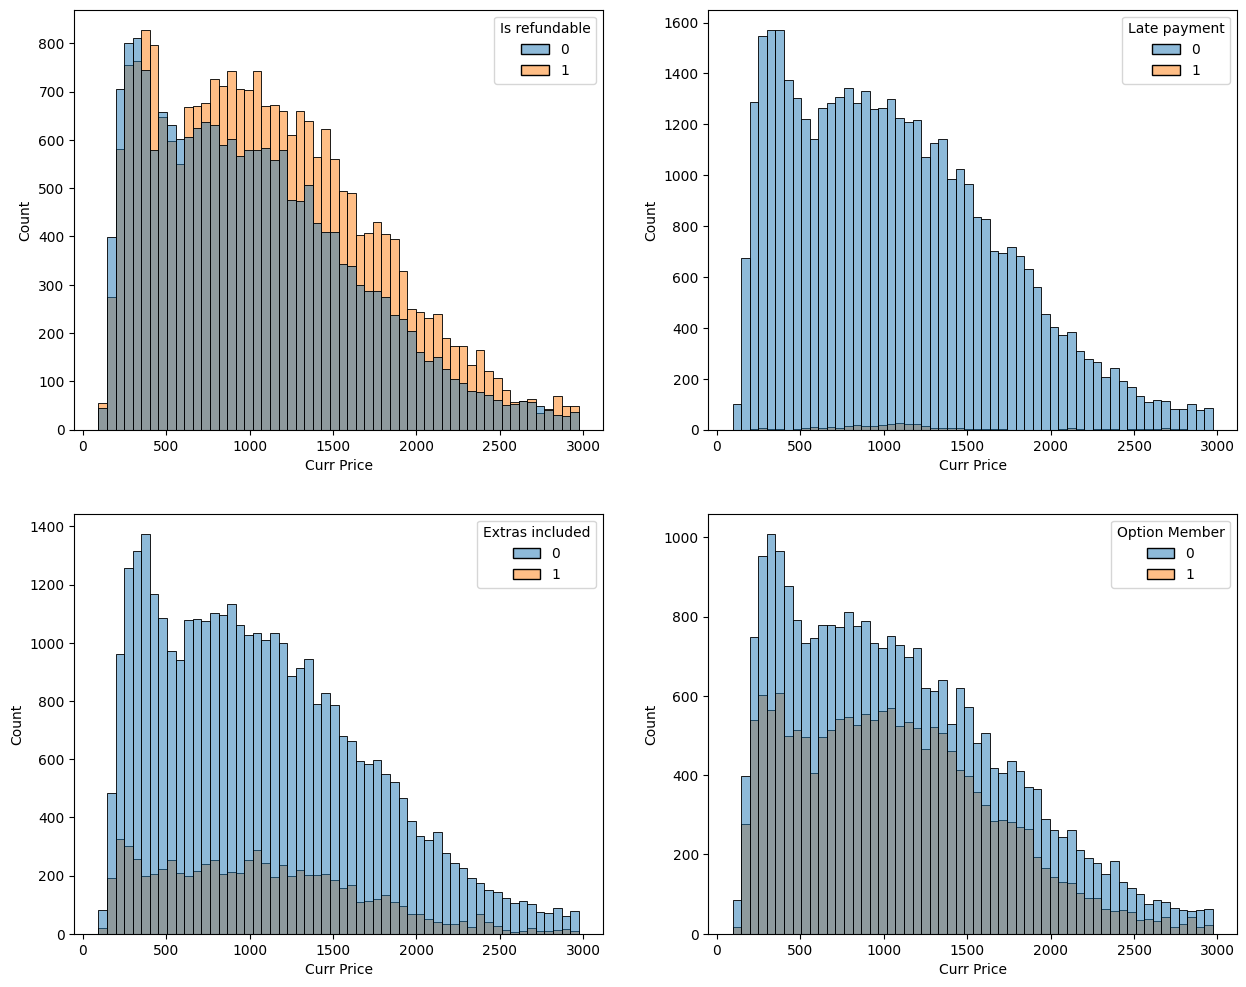

In [42]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
for col,ax in zip(expedia_df.columns[10:],axes.flatten()):
    sns.histplot(data=expedia_df,x='Curr Price',ax=ax,hue = col)

מכאן ניתן להסיק שאין הבדל בהתפלגות המחירים בין הקטגוריות של העמודות הנ"ל , לכן העמודות יהיו פחות רלוונטיות כשמדובר במודלים כמו עץ/רנדום פורסט 

count         mean         std   min    25%     50%  \
Grade                43541.0     8.341207    0.723200   5.6    8.0     8.4   
Num of Reviews       43541.0  1054.697366  659.745057   0.0  998.0  1002.0   
Curr Price           43541.0  1075.581140  615.205593  94.2  566.4   999.9   
Original Price       43541.0  1179.406066  723.154552  94.2  597.8  1066.7   
Percent of discount  43541.0     0.066853    0.088419   0.0    0.0     0.0   

                         75%      max  
Grade                   8.80    10.00  
Num of Reviews       1142.00  6080.00  
Curr Price           1480.20  2972.40  
Original Price       1615.30  5774.90  
Percent of discount     0.13     0.51

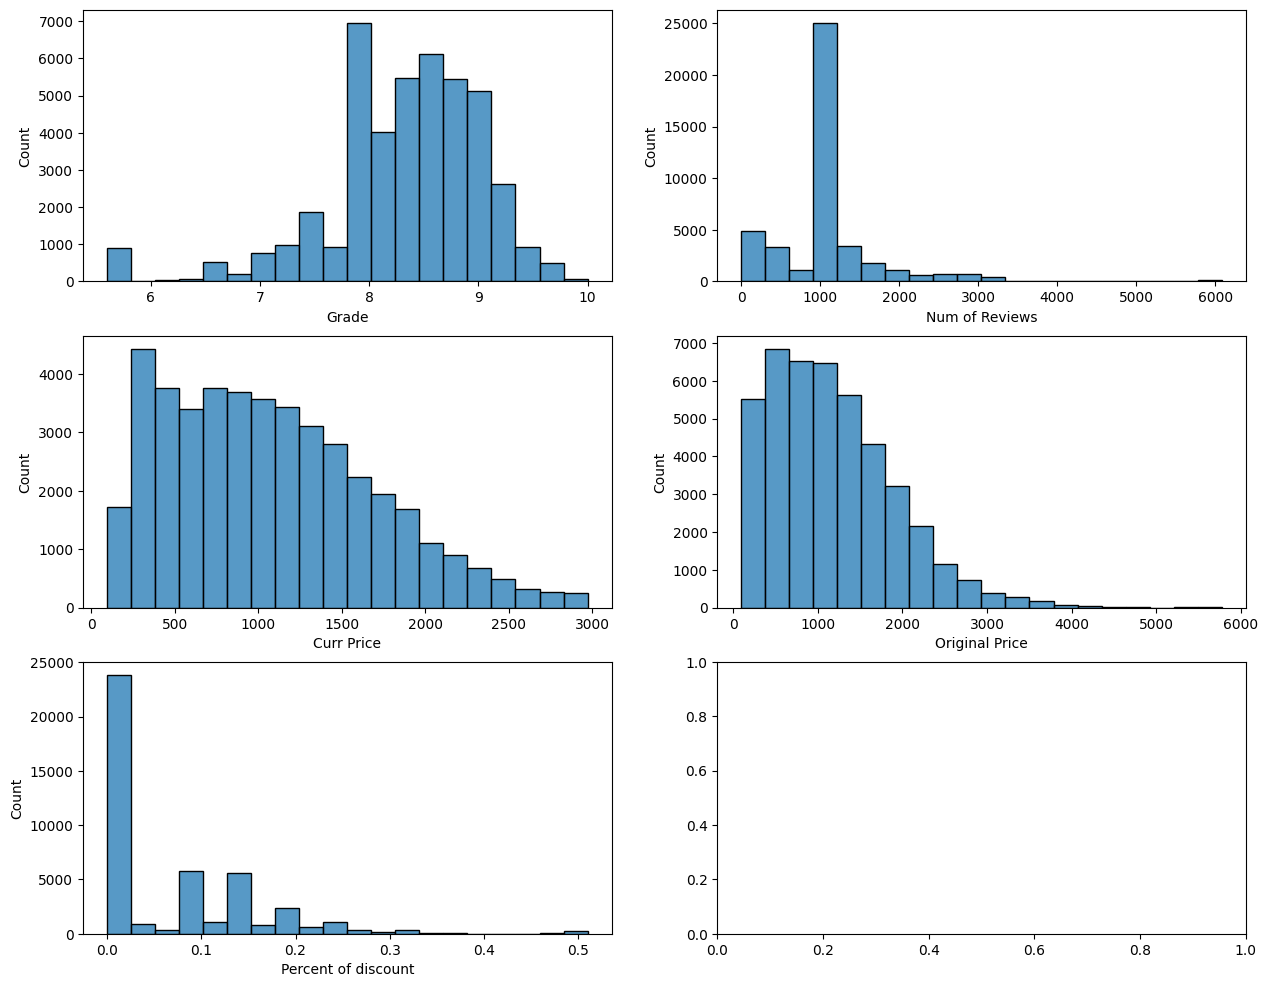

In [43]:
cols = expedia_df.columns[5:10]
fig,axes = plt.subplots(3,2,figsize=(15,12))
for col,ax in zip(cols,axes.flatten()):
    sns.histplot(data=expedia_df,x=col,ax=ax, bins=20)
    
expedia_df[cols].describe().T

לגבי עמודות המחירים - ניתן לראות שבמידה ונוריד את הערכים החריגים נקבל התפלגות די נורמאלית
לגבי אחוזי ההנחה - ניתן לראות שיותר מחצי מהמלונות ללא הנחה
לגבי ציוני המלונות - ניתן לראות שעיקר המלונות הם בין ציון 8 ל9
לגבי מספר התגובות - רוב המלונות עם כ1000 תגובות

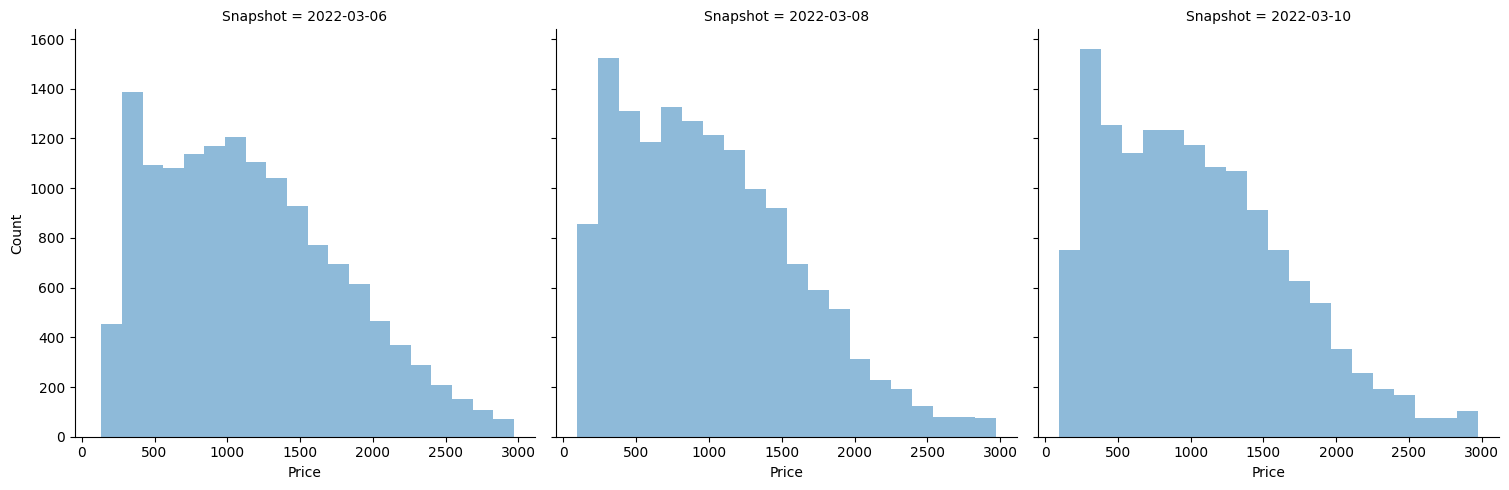

count         mean         std    min    25%     50%     75%  \
Snapshot                                                                     
2022-03-06  14348.0  1157.851533  623.632319  134.4  644.8  1085.2  1579.2   
2022-03-08  14641.0  1022.371607  600.124953   95.8  526.1   943.2  1413.8   
2022-03-10  14552.0  1047.999031  613.509114   94.2  534.2   972.1  1453.1   

               max  
Snapshot            
2022-03-06  2969.4  
2022-03-08  2972.4  
2022-03-10  2971.6

In [44]:
# Create a FacetGrid with three histograms
g = sns.FacetGrid(expedia_df, col='Snapshot', height=5, aspect=1)
g = g.map(plt.hist, 'Curr Price', alpha=0.5, bins=20)

# Add labels to the plot
g.set_axis_labels('Price', 'Count')
plt.show()

expedia_df.groupby('Snapshot')['Curr Price'].describe()


למרות שהתאריך הראשון בעל ממוצע וחציון יותר גבוהים במחירים, ניתן להסיק כי אין הבדל משמעותי בין שלושת התאריכים ומכאן שלא תהיה משמעות להפוך את העמודה לאורדינאלית

In [45]:
expedia_df.replace({'Snapshot': {pd.datetime(2022,3,6).date() : 'Monday', pd.datetime(2022,3,8).date() : 'Wednesday', pd.datetime(2022,3,10).date() : 'Friday'}}, inplace=True)

In [46]:
expedia_df = expedia_df.join(pd.get_dummies(expedia_df['Snapshot']))


In [47]:
expedia_df.columns

Index(['Snapshot', 'Index', 'Hotel Name', 'TTT', 'LOS', 'Grade',
       'Num of Reviews', 'Curr Price', 'Original Price', 'Percent of discount',
       'Is refundable', 'Late payment', 'Extras included', 'Option Member',
       'Friday', 'Monday', 'Wednesday'],
      dtype='object')

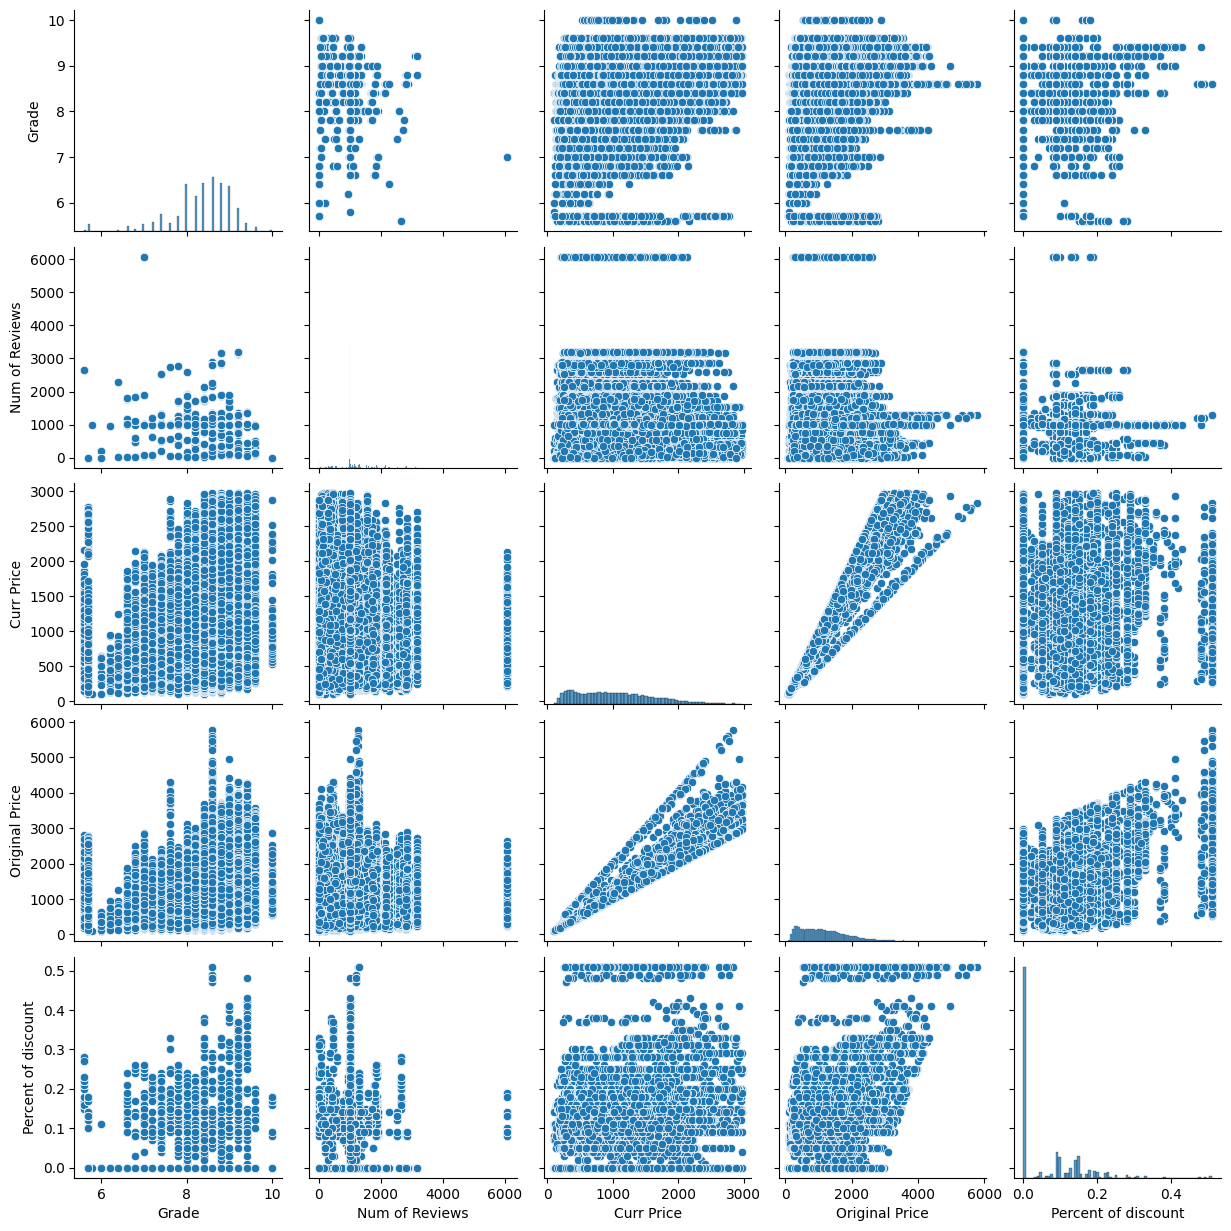

In [48]:
sns.pairplot(expedia_df.iloc[:,5:10])

<Axes: xlabel='TTT', ylabel='Curr Price'>

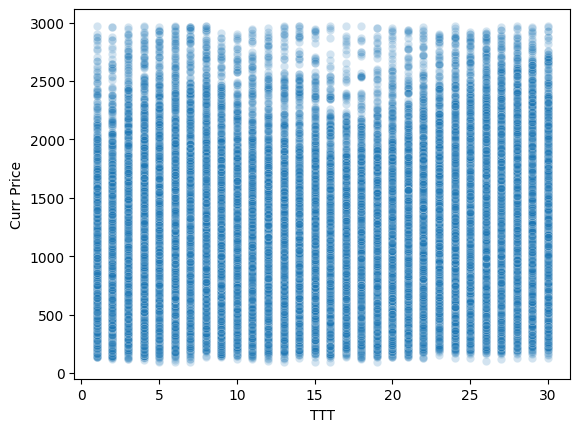

In [49]:
sns.scatterplot(data =expedia_df, x = 'TTT', y = 'Curr Price', alpha = 0.2)

העמודה לא ממש יוצרת הבדל במחירים, ככל שהימים שנותרו להזמנה קטנים יותר ניתן לראות יותר מלונות עם מחירים חריגים וגבוהים אבל אי אפשר להגדיר את זה כתבנית של הנתונים

count         mean         std    min     25%     50%       75%     max
LOS                                                                          
1    9000.0   369.569000  176.534117   94.2   255.7   334.4   425.225  1447.0
2    9000.0   774.154011  345.262663  187.3   554.4   700.5   883.150  2660.1
3    8857.0  1140.028520  444.180098  281.5   843.5  1053.0  1311.200  2970.5
4    8485.0  1444.496547  447.788545  374.6  1125.0  1384.7  1679.200  2970.5
5    8199.0  1730.038480  451.365923  468.9  1398.5  1712.6  2017.500  2972.4

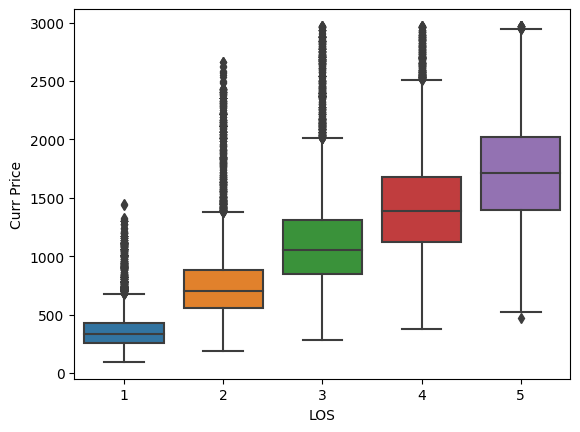

In [50]:
sns.boxplot(data =expedia_df, x = 'LOS', y = 'Curr Price')
expedia_df.groupby('LOS')['Curr Price'].describe()

כמות הלילות של ההזמנה לא משפיעה על המחיר ללילה של המלון

<Axes: xlabel='Index', ylabel='Curr Price'>

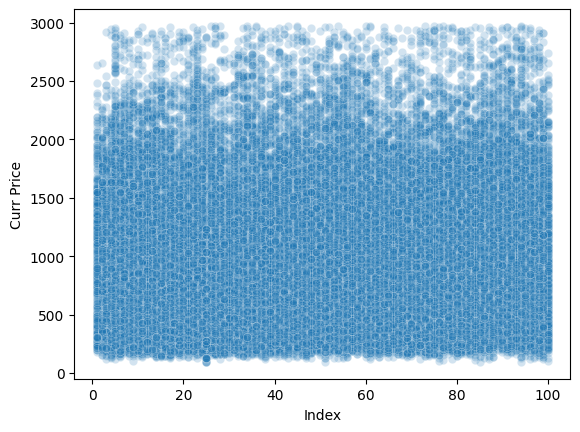

In [51]:
sns.scatterplot(data =expedia_df, x = 'Index', y = 'Curr Price', alpha = 0.2)

ניתן לראות שבדרך כלל במקומות הראשונים לא מוצגים המלונות היקרים

<Axes: xlabel='Num of Reviews', ylabel='Curr Price'>

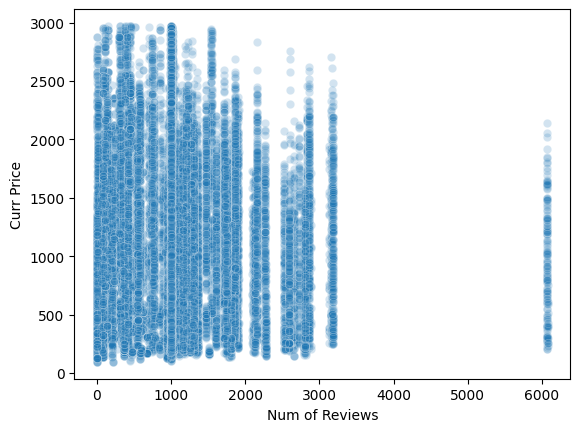

In [52]:
sns.scatterplot(data =expedia_df, x = 'Num of Reviews', y = 'Curr Price', alpha = 0.2)

רוב המלונות היקרים עם פחות תגובות מהממוצע - 1000 תגובות

<Axes: xlabel='Percent of discount', ylabel='Count'>

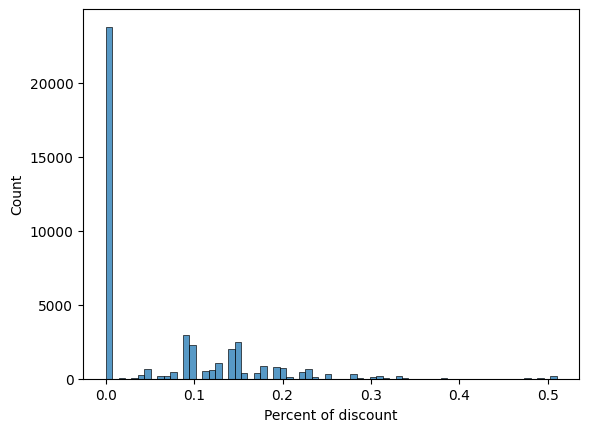

In [53]:
sns.histplot(data = expedia_df, x = 'Percent of discount')

<Axes: xlabel='Percent of discount', ylabel='Curr Price'>

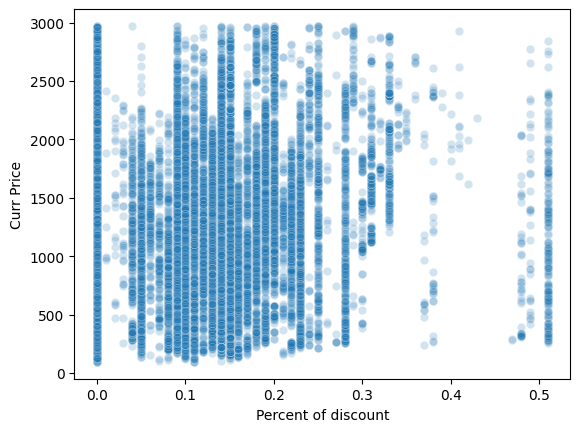

In [54]:
sns.scatterplot(data =expedia_df, x = 'Percent of discount', y = 'Curr Price', alpha = 0.2)

ניתן לראות כי לרוב המוחלט של המלונות אין הנחה , לכן נחליט להפוך את העמודה להאם יש הנחה או אין

In [55]:
expedia_df['Discount'] = expedia_df['Percent of discount'].apply(lambda x : 1 if x != 0 else 0)
expedia_df.drop(['Percent of discount'], axis = 1, inplace=True)

In [56]:
'''expedia_hotels_frequency = expedia_df['Hotel Name'].value_counts()
expedia_hotels_mean = expedia_df.groupby('Hotel Name').mean()['Curr Price']

merged_hotels = pd.merge(expedia_hotels_frequency, expedia_hotels_mean, left_index=True, right_index=True)

merged_hotels.head(10)
merged_hotels.sort_values(by = 'Curr Price', ascending= False, inplace=True)

sns.catplot(x=merged_hotels.index , y='Curr Price', hue='Hotel Name', kind='bar', data=merged_hotels, palette='viridis')'''


"expedia_hotels_frequency = expedia_df['Hotel Name'].value_counts()\nexpedia_hotels_mean = expedia_df.groupby('Hotel Name').mean()['Curr Price']\n\nmerged_hotels = pd.merge(expedia_hotels_frequency, expedia_hotels_mean, left_index=True, right_index=True)\n\nmerged_hotels.head(10)\nmerged_hotels.sort_values(by = 'Curr Price', ascending= False, inplace=True)\n\nsns.catplot(x=merged_hotels.index , y='Curr Price', hue='Hotel Name', kind='bar', data=merged_hotels, palette='viridis')"

<Axes: >

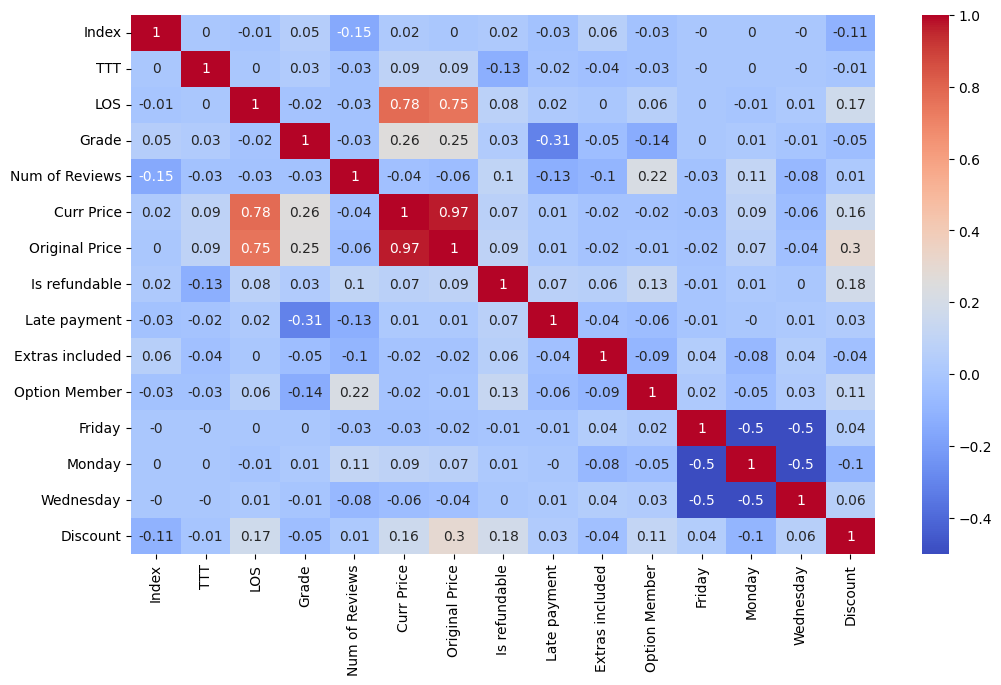

In [57]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(expedia_df.corr().round(2), annot=True, ax=ax, cmap='coolwarm')

In [58]:
expedia_df.corr()['Curr Price'].sort_values(ascending=False)


Curr Price         1.000000
Original Price     0.970145
LOS                0.777059
Grade              0.260679
Discount           0.161524
TTT                0.094897
Monday             0.093753
Is refundable      0.074606
Index              0.023930
Late payment       0.012362
Option Member     -0.018798
Extras included   -0.022021
Friday            -0.031766
Num of Reviews    -0.043244
Wednesday         -0.061562
Name: Curr Price, dtype: float64

ניתן לראות שלציון המלון יש קורלציה גבוהה יחסית לשאר עם המחיר של המלון, לכן כדאי לדאוג שהדאתא של הלמידה ושל האימון יהיו מאוזנים ביחס לציון של המלונות

<Axes: xlabel='LOS', ylabel='Curr Price'>

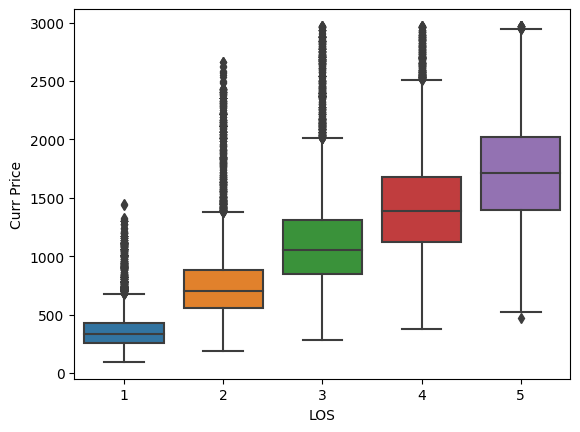

In [164]:
sns.boxplot(data = expedia_df, x = 'LOS', y = 'Curr Price')

ניתן לפצל את הדאתא לבינים לפי ההיסטוגרמה הנ"ל

In [165]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(expedia_df, expedia_df['LOS']):
    strat_train_set = expedia_df.loc[train_index]
    strat_test_set = expedia_df.loc[test_index]

In [166]:
strat_test_set["LOS"].value_counts() / len(strat_test_set)


2    0.206691
1    0.206691
3    0.203399
4    0.194902
5    0.188318
Name: LOS, dtype: float64

In [167]:
expedia_df["LOS"].value_counts() / len(expedia_df)


1    0.206702
2    0.206702
3    0.203417
4    0.194874
5    0.188305
Name: LOS, dtype: float64

דאגנו לכך שהחלק יחסי של קטגוריית ציון יהיה שווה גם באימון וגם בלמידה

In [66]:
expedia_df.head()

Snapshot  Index                         Hotel Name  TTT  LOS  Grade  \
0   Monday      1                        Hotel 32 32    1    1    8.0   
1   Monday      2  Sonesta Simply Suites Jersey City    1    1    8.4   
2   Monday      3                 Park Lane New York    1    1    8.8   
3   Monday      4                       Arlo Midtown    1    1    9.2   
4   Monday      5      PUBLIC, an Ian Schrager hotel    1    1    8.0   

   Num of Reviews  Curr Price  Original Price  Is refundable  Late payment  \
0          1296.0       303.8           393.4              0             0   
1          1002.0       237.2           237.2              1             0   
2           305.0       490.7           538.8              0             0   
3          3123.0       358.5           358.5              1             0   
4          1465.0       467.8           467.8              0             0   

   Extras included  Option Member  Friday  Monday  Wednesday  Discount  
0                0              0       0       1          0         1  
1                0              0       0       1          0         0  
2                0              0       0       1          0         1  
3                0              1       0       1          0         0  
4                0              1       0       1          0         0

# Booking cleaning

In [67]:
booking_df = pd.read_csv(r"C:\Users\yarin\Data Science - College Of Management\Year 2\Semester 2\Data Science Fundementals\Final Project\DSF-final project\Notebooks\Booking\Booking_hotels.csv")


In [68]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Snapshot              45000 non-null  object 
 1   Index                 45000 non-null  int64  
 2   Hotel Name            45000 non-null  object 
 3   TTT                   45000 non-null  int64  
 4   LOS                   45000 non-null  int64  
 5   Grade                 45000 non-null  float64
 6   Num of Reviews        45000 non-null  object 
 7   Curr Price            45000 non-null  object 
 8   Original Price        45000 non-null  object 
 9   Distance from center  45000 non-null  object 
 10  Type of room          45000 non-null  object 
 11  Location grade        20488 non-null  object 
 12  Extra Data            45000 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 4.5+ MB


In [69]:
booking_df.head()


Snapshot  Index                          Hotel Name  TTT  \
0  2023-03-06 11:24:01.241227      1  Margaritaville Resort Times Square    1   
1  2023-03-06 11:24:01.241227      2           33 Seaport Hotel New York    1   
2  2023-03-06 11:24:01.241227      3                 The Belvedere Hotel    1   
3  2023-03-06 11:24:01.241227      4                      CIVILIAN Hotel    1   
4  2023-03-06 11:24:01.241227      5     The Cloud One New York-Downtown    1   

   LOS  Grade Num of Reviews                Curr Price  \
0    1    8.8  1,369 reviews                     ₪ 752   
1    1    8.6    284 reviews  ₪ 1,050\r\nPrice ₪ 1,050   
2    1    8.0  3,644 reviews                     ₪ 510   
3    1    8.5  1,172 reviews                     ₪ 767   
4    1    8.2    518 reviews                     ₪ 620   

             Original Price Distance from center             Type of room  \
0                     ₪ 752   1.5 km from center      Standard Queen Room   
1  ₪ 1,050\r\nPrice ₪ 1,050   6.9 km from center  Superior Courtyard King   
2                     ₪ 510   0.9 km from center       Standard King Room   
3                     ₪ 767   0.9 km from center              Double Room   
4                     ₪ 620     7 km from center       Standard King Room   

  Location grade                                         Extra Data  
0   Location 9.4  Standard Queen Room\r\n1 queen bed\r\nOnly 1 r...  
1            NaN              Superior Courtyard King\r\n1 king bed  
2   Location 9.4  Standard King Room\r\n1 king bed\r\nOnly 2 roo...  
3   Location 9.5                         Double Room\r\n1 queen bed  
4            NaN  Standard King Room\r\n1 king bed\r\nFREE cance...

In [70]:
# extracting numeric data and removing useless text from prices, location grade, and review. normalize distance from center to m' instead of km, and inserts -1 instead of NaNs

#booking_df = pd.read_csv(r"C:\Users\royzo\DS-project\Notebooks\Booking\Booking_hotels.csv")
booking_df[['del', 'Curr Price']] = booking_df['Curr Price'].str.split(' ', 1, expand = True)
booking_df[['Curr Price','del2']] = booking_df['Curr Price'].str.split(r"\r", 0, expand = True)
booking_df[['del', 'Original Price']] = booking_df['Original Price'].str.split(' ', 1, expand = True)
booking_df[['Original Price','del2']] = booking_df['Original Price'].str.split(r"\r", 0, expand = True)
booking_df[['Num of Reviews', 'del']] = booking_df['Num of Reviews'].str.split(' ', 1, expand = True)
booking_df['Num of Reviews'] = booking_df['Num of Reviews'].apply(lambda x: int(float(x.replace(',',''))))


booking_df['Distance from center'] = booking_df['Distance from center'].apply(lambda a: int(float(a.split(' ')[0])*1000) if a.split(' ')[1] == 'km' else int(a.split(' ')[0]))
booking_df[['del', 'Location grade']] = booking_df['Location grade'].str.split(' ', 1, expand = True)
booking_df['Location grade'] = booking_df['Location grade'].apply(lambda a: -1 if pd.isna(a) else a)
booking_df["Location grade"] = booking_df["Location grade"].apply(lambda a: float(a))

booking_df = booking_df.drop(columns=['del', 'del2'])

In [71]:
# from datetime to date

booking_df['Snapshot'] = pd.to_datetime(booking_df['Snapshot']).dt.date
booking_df

Snapshot  Index                                         Hotel Name  \
0      2023-03-06      1                 Margaritaville Resort Times Square   
1      2023-03-06      2                          33 Seaport Hotel New York   
2      2023-03-06      3                                The Belvedere Hotel   
3      2023-03-06      4                                     CIVILIAN Hotel   
4      2023-03-06      5                    The Cloud One New York-Downtown   
...           ...    ...                                                ...   
44995  2023-03-10     96      Aloft Manhattan Downtown - Financial District   
44996  2023-03-10     97  Hampton Inn Manhattan/Downtown- Financial Dist...   
44997  2023-03-10     98                                     Leon Hotel LES   
44998  2023-03-10     99                                            SoHo 54   
44999  2023-03-10    100                          New York Marriott Marquis   

       TTT  LOS  Grade  Num of Reviews Curr Price Original Price  \
0        1    1    8.8            1369        752            752   
1        1    1    8.6             284      1,050          1,050   
2        1    1    8.0            3644        510            510   
3        1    1    8.5            1172        767            767   
4        1    1    8.2             518        620            620   
...    ...  ...    ...             ...        ...            ...   
44995   30    5    7.5            1106      3,841          3,841   
44996   30    5    7.6             658      4,459          4,459   
44997   30    5    8.1            1309      5,398          6,748   
44998   30    5    6.9            1562      3,840          4,266   
44999   30    5    8.2            1712      7,115          7,115   

       Distance from center                                    Type of room  \
0                      1500                             Standard Queen Room   
1                      6900                         Superior Courtyard King   
2                       900                              Standard King Room   
3                       900                                     Double Room   
4                      7000                              Standard King Room   
...                     ...                                             ...   
44995                  6800                             Guest room, 1 Queen   
44996                  7700                                      Queen Room   
44997                  5900                             Superior Queen Room   
44998                  5300                                       SoHo King   
44999                  1100  Renovated Deluxe, Guest room, 1 King, Sofa bed   

       Location grade                                         Extra Data  
0                 9.4  Standard Queen Room\r\n1 queen bed\r\nOnly 1 r...  
1                -1.0              Superior Courtyard King\r\n1 king bed  
2                 9.4  Standard King Room\r\n1 king bed\r\nOnly 2 roo...  
3                 9.5                         Double Room\r\n1 queen bed  
4                -1.0  Standard King Room\r\n1 king bed\r\nFREE cance...  
...               ...                                                ...  
44995            -1.0  Guest room, 1 Queen\r\n1 queen bed\r\nFree can...  
44996            -1.0  Queen Room\r\n1 queen bed\r\nFREE cancellation...  
44997            -1.0  Superior Queen Room\r\n1 queen bed\r\nFREE can...  
44998            -1.0  SoHo King\r\n1 king bed\r\nFREE cancellation •...  
44999             9.5  Renovated Deluxe, Guest room, 1 King, Sofa bed...  

[45000 rows x 13 columns]

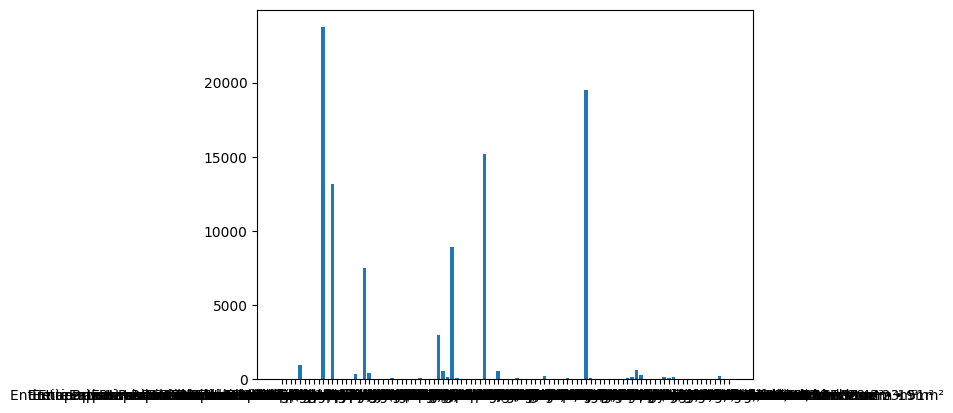

In [72]:
#breaking down 'Extra Data' to categories

op_set = set()
#row = df.head(1)
for index, row in booking_df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    for item in line_list:
        op_set.add(item)

op_list = []
for index, row in booking_df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    for item in line_list:
        op_list.append(item)

op_dict = {}
for set_item in op_set:
    count = 0
    for list_item in op_list:
        if list_item == set_item:
            count = count + 1
            
    op_dict[set_item] = count 

names = list(op_dict.keys())
values = list(op_dict.values())

plt.bar(range(len(op_dict)), values, tick_label=names)
plt.show()

In [73]:
# focusing on top categories, ignoring bed count and other generic cats
sorted(op_dict.items(), key=lambda x: x[1], reverse=True)

[('FREE cancellation • No prepayment needed', 23734),
 ('1 king bed', 19514),
 ('You can cancel later, so lock in this great price today!', 15192),
 ('1 queen bed', 13172),
 ('Breakfast included', 8929),
 ('Free cancellation', 7520),
 ('1 full bed', 2975),
 ('2 full beds', 972),
 ('Private suite', 599),
 ('2 beds (1 king, 1 sofa bed)', 560),
 ('1 bunk bed', 558),
 ('2 twin beds', 455),
 ('2 queen beds', 354),
 ('Entire studio • 1 bathroom • 19m²', 317),
 ('Entire studio • 1 bathroom • 25m²', 239),
 ('2 beds (1 sofa bed, 1 queen)', 216),
 ('Entire studio • 1 bathroom • 325m²', 172),
 ('Entire studio • 1 bathroom • 18m²', 166),
 ('Entire studio • 1 bathroom • 20m²', 160),
 ('Private suite • 1 bedroom • 1 living room • 1 bathroom • 28m²', 138),
 ('1 twin bed', 115),
 ('Entire studio • 1 bathroom • 28m²', 96),
 ('Entire studio • 1 bathroom • 29m²', 65),
 ('Beds: 1 double or 2 twins', 64),
 ('Private suite • 1 bedroom • 1 living room • 1 bathroom • 30m²', 63),
 ('4 twin beds', 62),
 ('Entir

In [74]:
# combining cats for free cancelation and comparing counts
cancellation_count = 0
for index, row in booking_df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    if ('FREE cancellation • No prepayment needed' in line_list) or ('Free cancellation' in line_list):
        cancellation_count = cancellation_count + 1
        
print(cancellation_count)

booking_df['Free Cancellation'] = booking_df['Extra Data'].apply(lambda a: 1 if 
                                                 ('FREE cancellation • No prepayment needed' in a.split('\r\n')) 
                                                 or ('Free cancellation' in a.split('\r\n')) else 0)
booking_df.groupby('Free Cancellation').count()

31254


Snapshot  Index  Hotel Name    TTT    LOS  Grade  \
Free Cancellation                                                     
0                     13746  13746       13746  13746  13746  13746   
1                     31254  31254       31254  31254  31254  31254   

                   Num of Reviews  Curr Price  Original Price  \
Free Cancellation                                               
0                           13746       13746           13746   
1                           31254       31254           31254   

                   Distance from center  Type of room  Location grade  \
Free Cancellation                                                       
0                                 13746         13746           13746   
1                                 31254         31254           31254   

                   Extra Data  
Free Cancellation              
0                       13746  
1                       31254

In [75]:
# converting top categories to bool

booking_df['No prepayment needed'] = booking_df['Extra Data'].apply(lambda a: 1 if 
                                                 ('FREE cancellation • No prepayment needed' in a.split('\r\n')) else 0)
booking_df['Breakfast included'] = booking_df['Extra Data'].apply(lambda a: 1 if 
                                                 ('Breakfast included' in a.split('\r\n')) else 0)
booking_df['Cancel Later'] = booking_df['Extra Data'].apply(lambda a: 1 if 
                                                 ('You can cancel later, so lock in this great price today!' in a.split('\r\n')) else 0)
booking_df = booking_df.drop(columns=['Extra Data'])

In [76]:
#converting ILS to USD for comparison to expedia
c = CurrencyRates()
x = booking_df['Snapshot'].unique()
curr_dict = {}
for date in x:
    curr_dict[date] = c.get_rate('ILS','USD', date)
    print(curr_dict[date])


0.27958937198067635
0.27958937198067635
0.27958937198067635


In [77]:
booking_df['Original Price'] = booking_df['Original Price'].apply(lambda x: int(x.replace(',','')))
booking_df['Curr Price'] = booking_df['Curr Price'].apply(lambda x: int(x.replace(',','')))

In [78]:
booking_df['Original Price'] = booking_df.apply(lambda x: (x['Original Price']*curr_dict[x['Snapshot']])  , axis = 1)
booking_df['Curr Price'] = booking_df.apply(lambda x: (x['Curr Price']*curr_dict[x['Snapshot']])  , axis = 1)

In [79]:
booking_df['Original Price'] = booking_df['Original Price'].apply(lambda x: round(x,2))
booking_df['Curr Price'] = booking_df['Curr Price'].apply(lambda x: round(x,2))

In [80]:
booking_df['Percent of discount'] = booking_df.apply(lambda x: 1 - (x['Curr Price']/x['Original Price'])  , axis = 1)
booking_df['Percent of discount'] = booking_df['Percent of discount'].apply(lambda x: round(x,2))

In [81]:
expedia_df.columns

Index(['Snapshot', 'Index', 'Hotel Name', 'TTT', 'LOS', 'Grade',
       'Num of Reviews', 'Curr Price', 'Original Price', 'Is refundable',
       'Late payment', 'Extras included', 'Option Member', 'Friday', 'Monday',
       'Wednesday', 'Discount'],
      dtype='object')

In [82]:
room_type = booking_df['Type of room'].unique()
print(room_type)
len(room_type)


['Standard Queen Room' 'Superior Courtyard King' 'Standard King Room'
 'Double Room' 'Deluxe King Room' 'Classic Room'
 'Renovated Deluxe, Guest room, 2 Double' 'King Room'
 'Executive Queen Suite with Sofa Bed'
 'Efficiency King Studio with Sofa Bed' 'Bunk Pod' 'Deluxe Family King'
 'Queen Garden Room' 'Newly Renovated Standard Queen Room' 'Queen Room'
 'Superior Double or Twin Room' 'Social City View Doubles' 'Standard Room'
 'King Room with City View' 'Queen Studio with Balcony'
 'Classic King Guest Room' 'Run of House' 'King Room - Disability Access'
 'Premium King Room with City View' 'Single Room' 'Superior Queen Room'
 'Deluxe Queen Room with Gotham View - Non-Smoking'
 'King Room - Disability Access/Shower'
 'Classic Double Room with Two Double Beds' 'Superior King Room'
 'King Room with Balcony' "Three's Company" 'Deluxe Two Queen Beds'
 'Standard Room with Queen Bed - Non-Smoking' 'Small Queen Room'
 'Double Room with Two Double Beds and Shower - Accessible'
 'Premier Two Dou

685

In [83]:
booking_df.head(600)

Snapshot  Index                                         Hotel Name  \
0    2023-03-06      1                 Margaritaville Resort Times Square   
1    2023-03-06      2                          33 Seaport Hotel New York   
2    2023-03-06      3                                The Belvedere Hotel   
3    2023-03-06      4                                     CIVILIAN Hotel   
4    2023-03-06      5                    The Cloud One New York-Downtown   
..          ...    ...                                                ...   
595  2023-03-06     96  Holiday Inn Express New York City Chelsea, an ...   
596  2023-03-06     97                          LUMA Hotel - Times Square   
597  2023-03-06     98  Embassy Suites By Hilton New York Manhattan Ti...   
598  2023-03-06     99                       Millennium Downtown New York   
599  2023-03-06    100  Fairfield Inn & Suites By Marriott New York Ma...   

     TTT  LOS  Grade  Num of Reviews  Curr Price  Original Price  \
0      1    1    8.8            1369      210.25          210.25   
1      1    1    8.6             284      293.57          293.57   
2      1    1    8.0            3644      142.59          142.59   
3      1    1    8.5            1172      214.45          214.45   
4      1    1    8.2             518      173.35          173.35   
..   ...  ...    ...             ...         ...             ...   
595    2    1    7.9            3013      224.79          224.79   
596    2    1    9.0            2108      364.30          364.30   
597    2    1    7.9            4111      306.71          306.71   
598    2    1    7.4            3596      265.61          265.61   
599    2    1    7.6            4579      286.30          286.30   

     Distance from center                                       Type of room  \
0                    1500                                Standard Queen Room   
1                    6900                            Superior Courtyard King   
2                     900                                 Standard King Room   
3                     900                                        Double Room   
4                    7000                                 Standard King Room   
..                    ...                                                ...   
595                  2400                                          King Room   
596                  1500  Metro King Room with Roll-In Shower - Disabili...   
597                  1900                        1 King Bed Studio with Sofa   
598                  6800                                 Superior King Room   
599                  1600                    Accessible, Guest room, 1 Queen   

     Location grade  Free Cancellation  No prepayment needed  \
0               9.4                  0                     0   
1              -1.0                  0                     0   
2               9.4                  0                     0   
3               9.5                  0                     0   
4              -1.0                  1                     1   
..              ...                ...                   ...   
595            -1.0                  0                     0   
596             9.7                  0                     0   
597             9.3                  1                     1   
598            -1.0                  1                     1   
599            -1.0                  0                     0   

     Breakfast included  Cancel Later  Percent of discount  
0                     0             0                  0.0  
1                     0             0                  0.0  
2                     0             0                  0.0  
3                     0             0                  0.0  
4                     0             1                  0.0  
..                  ...           ...                  ...  
595                   1             0                  0.0  
596                   0             0          

In [84]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Snapshot              45000 non-null  object 
 1   Index                 45000 non-null  int64  
 2   Hotel Name            45000 non-null  object 
 3   TTT                   45000 non-null  int64  
 4   LOS                   45000 non-null  int64  
 5   Grade                 45000 non-null  float64
 6   Num of Reviews        45000 non-null  int64  
 7   Curr Price            45000 non-null  float64
 8   Original Price        45000 non-null  float64
 9   Distance from center  45000 non-null  int64  
 10  Type of room          45000 non-null  object 
 11  Location grade        45000 non-null  float64
 12  Free Cancellation     45000 non-null  int64  
 13  No prepayment needed  45000 non-null  int64  
 14  Breakfast included    45000 non-null  int64  
 15  Cancel Later       

# Booking EDA

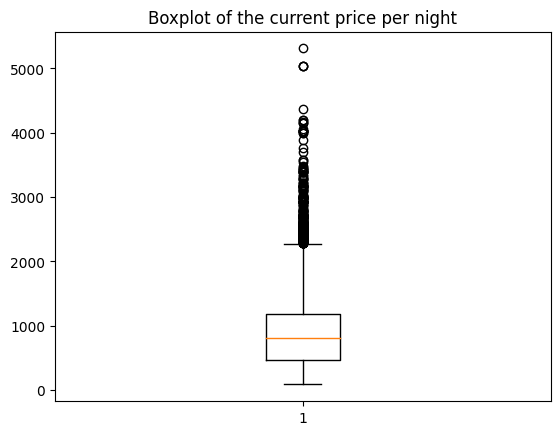

In [85]:
plt.boxplot(booking_df['Curr Price'])
plt.title('Boxplot of the current price per night')
plt.show()

In [86]:
q1 = booking_df['Curr Price'].quantile(0.25)
q3 = booking_df['Curr Price'].quantile(0.75)
iqr = q3-q1
top_lim = q3 + 1.5*iqr
bottom_lim = q1 - 1.5* iqr
booking_df = booking_df.drop(booking_df[booking_df['Curr Price'] > top_lim].index)
booking_df = booking_df.drop(booking_df[booking_df['Curr Price'] < bottom_lim].index)

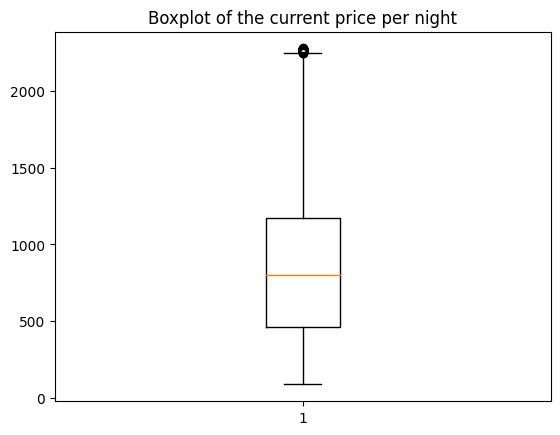

In [87]:
plt.boxplot(booking_df['Curr Price'])
plt.title('Boxplot of the current price per night')
plt.show()

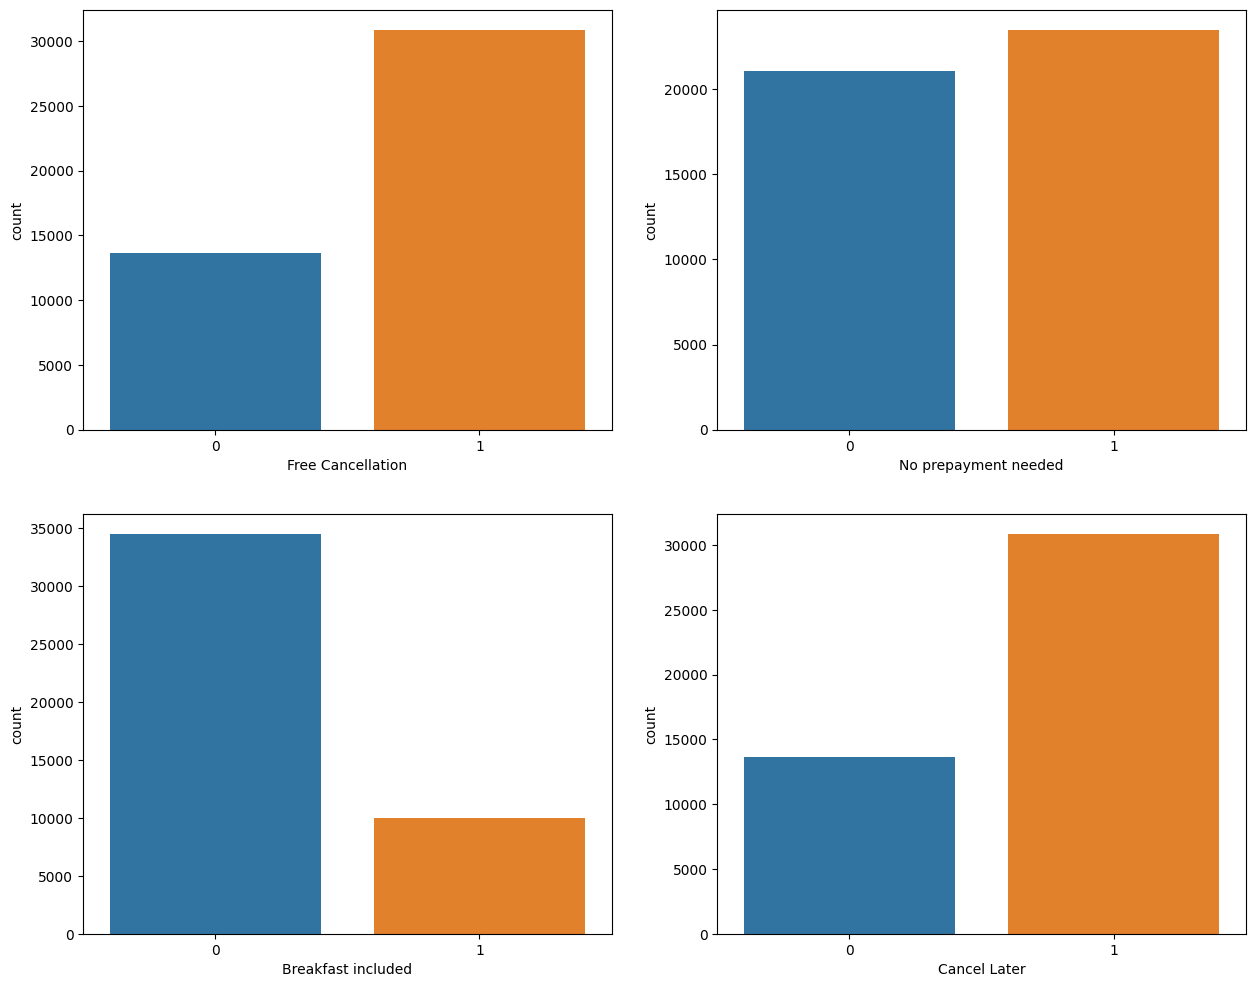

In [88]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
for col,ax in zip(booking_df.columns[12:16],axes.flatten()):
    sns.countplot(data=booking_df,x=col,ax=ax)

Free Cancellation mean: true  - false =  84.84632537063203
No prepayment needed mean: true  - false =  82.73541633798118
Breakfast included mean: true  - false =  -9.879954599653274
Cancel Later mean: true  - false =  84.84632537063203


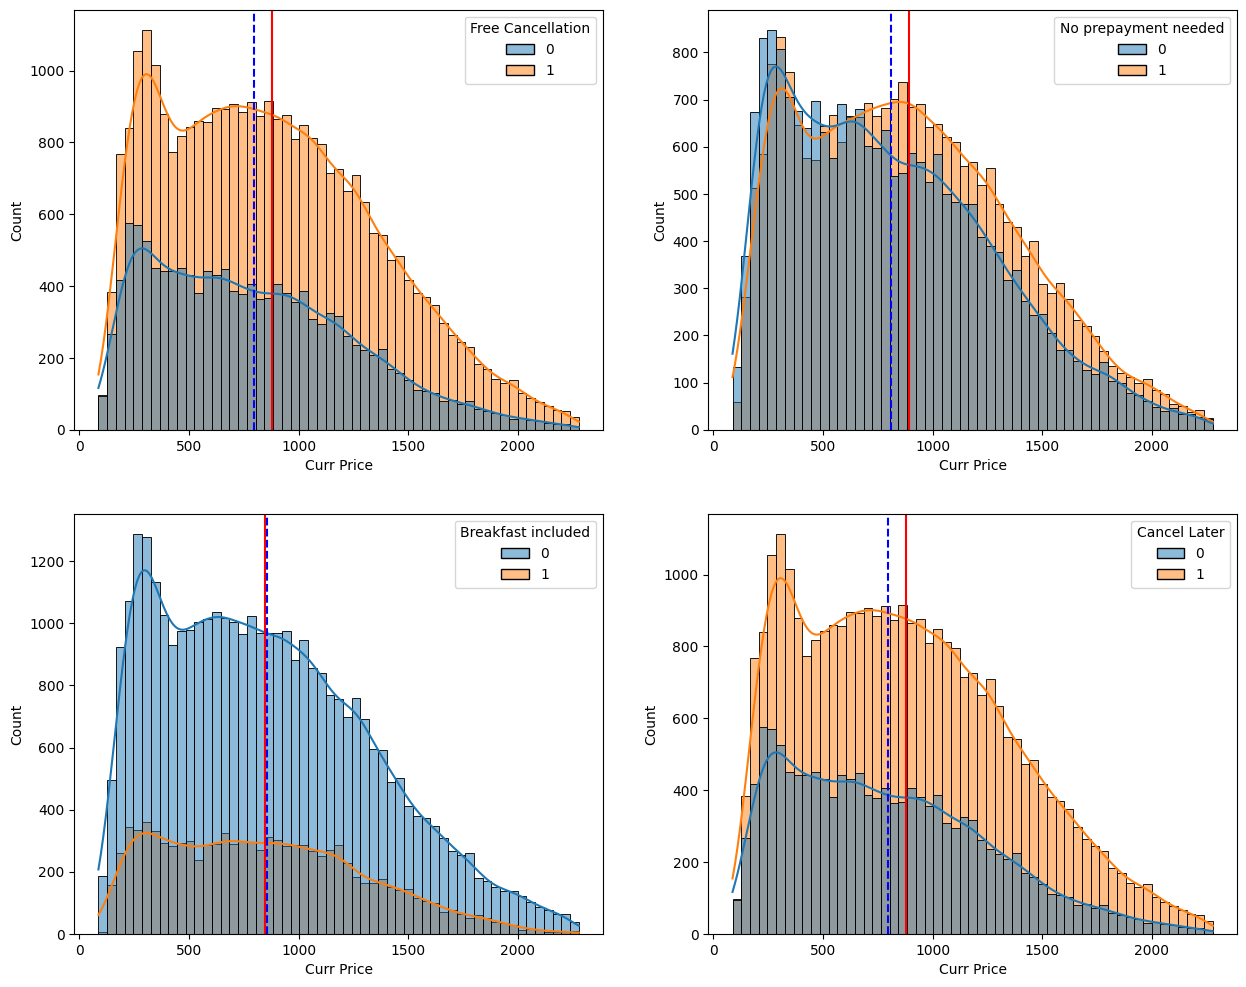

In [89]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
for col,ax in zip(booking_df.columns[12:16],axes.flatten()):
    sns.histplot(data=booking_df,x='Curr Price',ax=ax,hue = col ,kde =True)
    mean_1 =booking_df.loc[booking_df[col]==1, "Curr Price"].mean()
    ax.axvline(mean_1,c = 'r' , ls = '-')
    mean_0 =booking_df.loc[booking_df[col]==0, "Curr Price"].mean()
    ax.axvline(mean_0,c = 'b' , ls = '--' )
    print(col ,"mean: true  - false = " ,mean_1-mean_0 )

ניתן לראות שהממוצע יהיה יותר גדול משמע מחיר יותר יקר כאשר קיימים אחד מהפירים האלה:ביטול מאוחר, ביטול בחינם ותשלום מאוחר 

3combine  mean: true  - false =  82.73541633798118


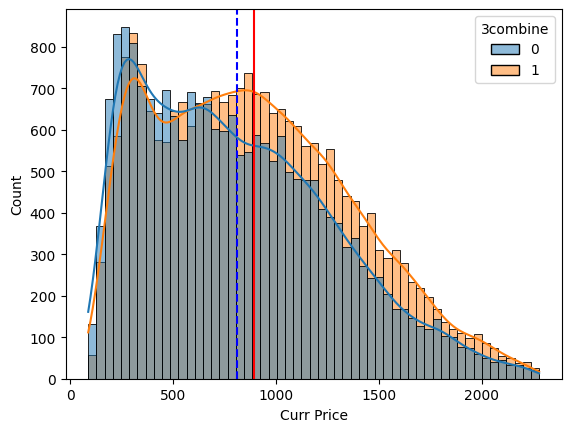

In [90]:

booking_df['3combine'] = booking_df['Free Cancellation'] +booking_df['No prepayment needed'] +booking_df['Cancel Later'] 
booking_df['3combine'] = booking_df['3combine'].apply(lambda x: 1 if x==3 else 0)
sns.histplot(data=booking_df,x='Curr Price',hue = '3combine' ,kde =True)
mean_1 =booking_df.loc[booking_df['3combine']==1, "Curr Price"].mean()
plt.axvline(mean_1,c = 'r' , ls = '-')
mean_0 =booking_df.loc[booking_df['3combine']==0, "Curr Price"].mean()
plt.axvline(mean_0,c = 'b' , ls = '--' )
booking_df.drop('3combine' , inplace = True ,axis =1)
print('3combine' ," mean: true  - false = " ,mean_1-mean_0 )

In [91]:
booking_df

Snapshot  Index                                         Hotel Name  \
0      2023-03-06      1                 Margaritaville Resort Times Square   
1      2023-03-06      2                          33 Seaport Hotel New York   
2      2023-03-06      3                                The Belvedere Hotel   
3      2023-03-06      4                                     CIVILIAN Hotel   
4      2023-03-06      5                    The Cloud One New York-Downtown   
...           ...    ...                                                ...   
44995  2023-03-10     96      Aloft Manhattan Downtown - Financial District   
44996  2023-03-10     97  Hampton Inn Manhattan/Downtown- Financial Dist...   
44997  2023-03-10     98                                     Leon Hotel LES   
44998  2023-03-10     99                                            SoHo 54   
44999  2023-03-10    100                          New York Marriott Marquis   

       TTT  LOS  Grade  Num of Reviews  Curr Price  Original Price  \
0        1    1    8.8            1369      210.25          210.25   
1        1    1    8.6             284      293.57          293.57   
2        1    1    8.0            3644      142.59          142.59   
3        1    1    8.5            1172      214.45          214.45   
4        1    1    8.2             518      173.35          173.35   
...    ...  ...    ...             ...         ...             ...   
44995   30    5    7.5            1106     1073.90         1073.90   
44996   30    5    7.6             658     1246.69         1246.69   
44997   30    5    8.1            1309     1509.22         1886.67   
44998   30    5    6.9            1562     1073.62         1192.73   
44999   30    5    8.2            1712     1989.28         1989.28   

       Distance from center                                    Type of room  \
0                      1500                             Standard Queen Room   
1                      6900                         Superior Courtyard King   
2                       900                              Standard King Room   
3                       900                                     Double Room   
4                      7000                              Standard King Room   
...                     ...                                             ...   
44995                  6800                             Guest room, 1 Queen   
44996                  7700                                      Queen Room   
44997                  5900                             Superior Queen Room   
44998                  5300                                       SoHo King   
44999                  1100  Renovated Deluxe, Guest room, 1 King, Sofa bed   

       Location grade  Free Cancellation  No prepayment needed  \
0                 9.4                  0                     0   
1                -1.0                  0                     0   
2                 9.4                  0                     0   
3                 9.5                  0                     0   
4                -1.0                  1                     1   
...               ...                ...                   ...   
44995            -1.0                  1                     0   
44996            -1.0                  1                     1   
44997            -1.0                  1                     1   
44998            -1.0                  1                     1   
44999             9.5                  0                     0   

       Breakfast included  Cancel Later  Percent of discount  
0                       0             0                  0.0  
1                       0             0                  0.0  
2                       0             0                  0.0  
3                       0             0                  0.0  
4                       0             1                  0.0  
...                   ...           ...                  ...  
44995                   0           

count         mean          std     min      25%  \
Grade                 44544.0     7.987433     0.589226    5.40     7.70   
Num of Reviews        44544.0  2252.411862  2503.794372    1.00   719.00   
Curr Price            44544.0   853.569544   471.469623   86.95   459.92   
Original Price        44544.0   890.787491   510.976813   86.95   470.83   
Distance from center  44544.0  2459.942978  1866.717133  150.00  1300.00   

                          50%      75%       max  
Grade                    8.10     8.40     10.00  
Num of Reviews        1362.00  2653.00  15029.00  
Curr Price             801.44  1175.95   2278.37  
Original Price         829.26  1223.76   4950.13  
Distance from center  1900.00  2700.00   9800.00

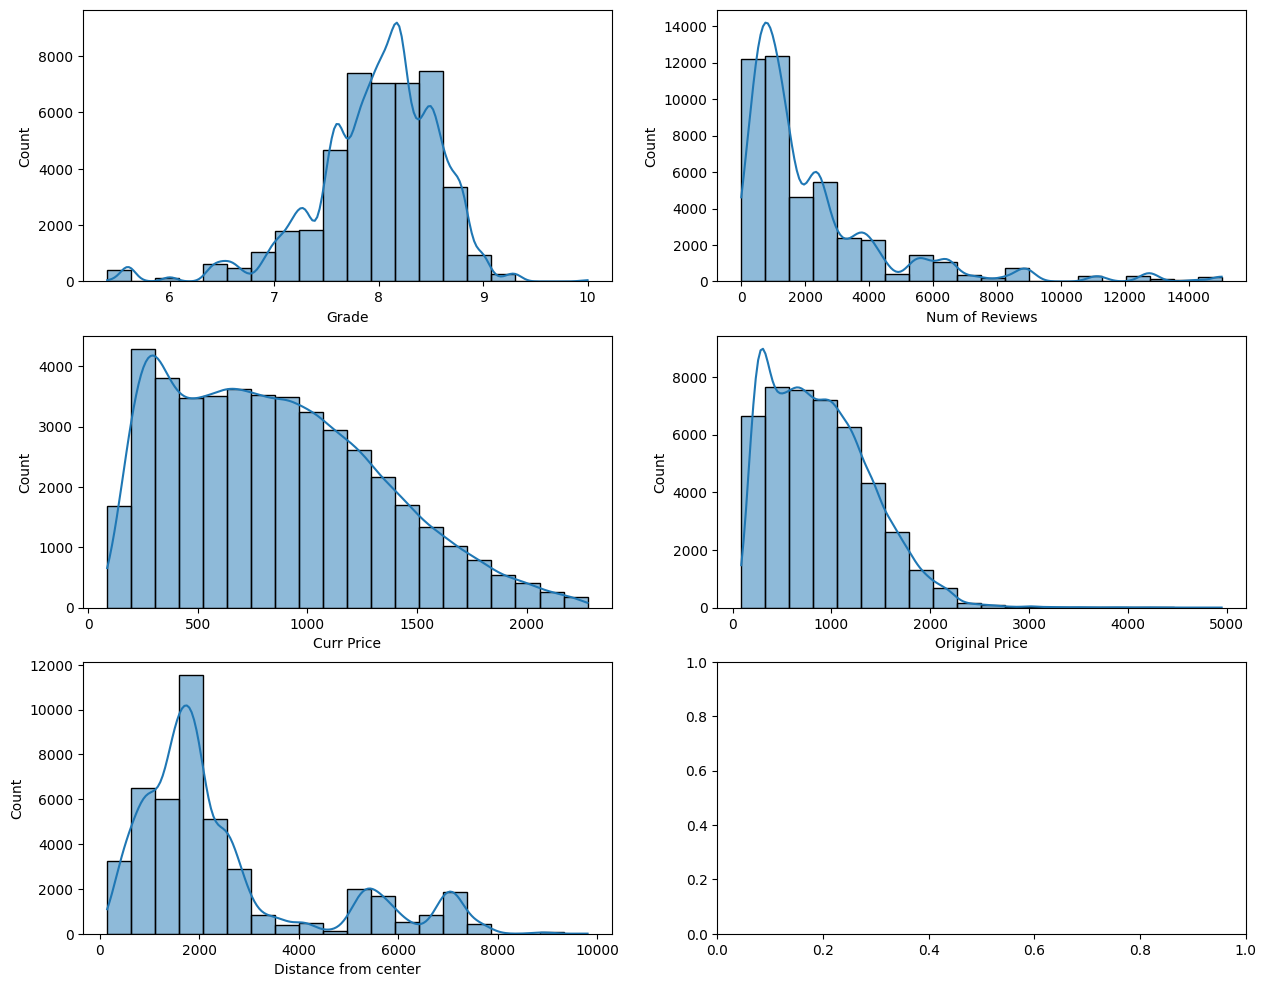

In [92]:
cols = booking_df.columns[5:10]
fig,axes = plt.subplots(3,2,figsize=(15,12))
for col,ax in zip(cols,axes.flatten()):
        sns.histplot(data=booking_df,x=col,ax=ax, bins=20 , kde =True)
    
booking_df[cols].describe().T

ציון -הציונים מתפלגים סביב 8
ביקורות - נוטה ימינה כך שהכי נפוץ כמות ביקורות בין 0 ל 2000
 המחיר כרגע - מתפלג נורצלית סביב  275
 המחיר המקורי - מתפלג נורמלית סביב 300
 מרחק מהמרכז - יש שני חלקים יש סוג מלונות מסויים שהוא מתפלג נורמלית בין 0 ל 3000 וסוג נוסף מתפלג בין 5000 ל 8000  

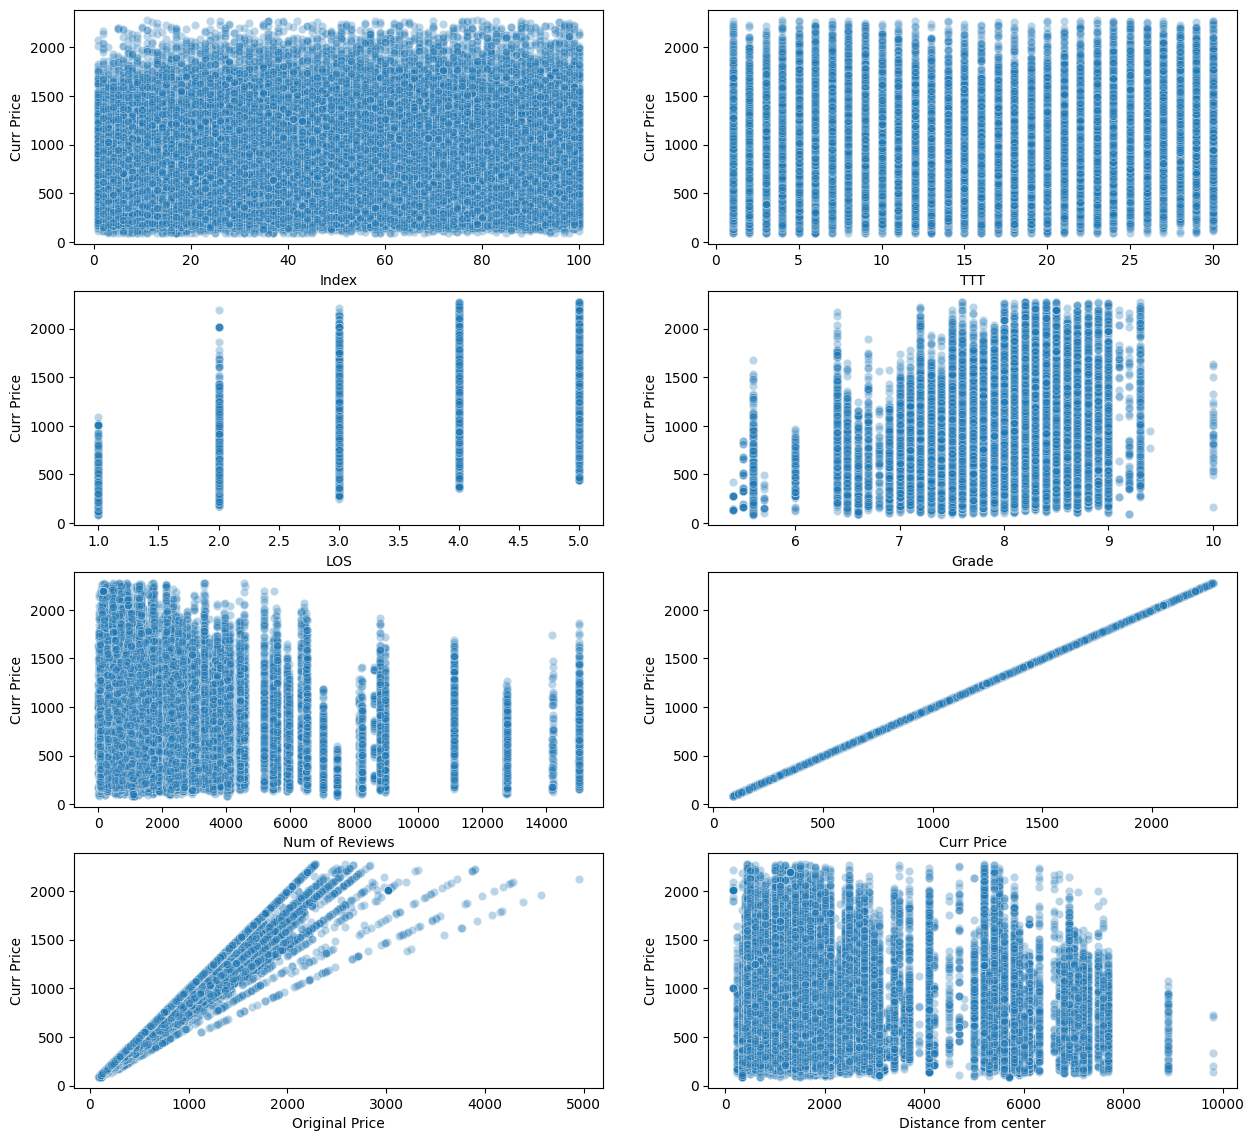

In [93]:
cols = booking_df.columns[1:10]
cols  = cols.drop(["Hotel Name"])
fig,axes = plt.subplots(4,2,figsize=(15,14))
for col,ax in zip(cols,axes.flatten()):
    sns.scatterplot(data = booking_df , x= col ,y = "Curr Price" , ax =ax ,alpha=0.3)
    

ציון - הציונים הנמוכים והגבוהים בעלי מחיר נמוך יחסית להתפלגות הציונים שהם ציונים בינוניים
ביקורות - ניתן לראות שהמלונות היקרים בעלי מספר נמוך של ביקורות
מחיר המקורי - מורכב מתתי קבוצות שמשקפים את המחיר כרגע
המרחק מהמרכז - ככול שהמרחק גדול יותר כך גם המלון זול יותר

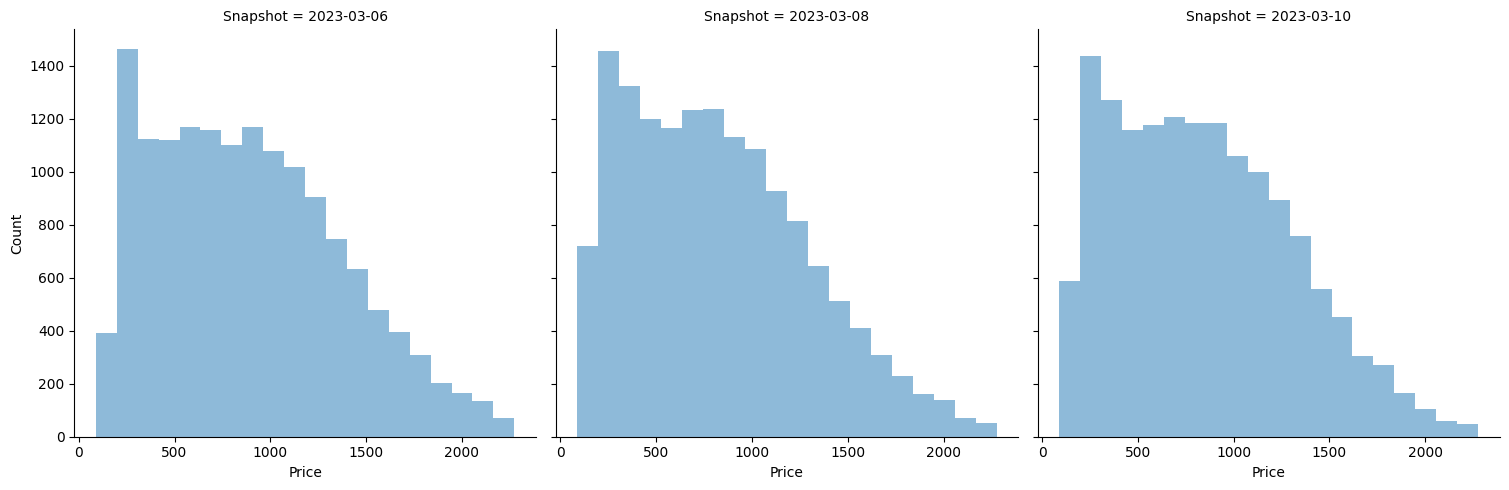

count        mean         std    min     25%     50%      75%  \
Snapshot                                                                      
2023-03-06  14840.0  888.865603  481.562977  89.47  489.21  841.28  1220.97   
2023-03-08  14828.0  826.249405  467.000392  86.95  434.48  769.43  1141.28   
2023-03-10  14876.0  845.590886  463.516565  87.79  457.13  796.55  1168.68   

                max  
Snapshot             
2023-03-06  2273.62  
2023-03-08  2278.37  
2023-03-10  2276.98

In [94]:
# Create a FacetGrid with three histograms
g = sns.FacetGrid(booking_df, col='Snapshot', height=5, aspect=1)
g = g.map(plt.hist, 'Curr Price', alpha=0.5, bins=20)

# Add labels to the plot
g.set_axis_labels('Price', 'Count')
plt.show()

booking_df.groupby('Snapshot')['Curr Price'].describe()

In [95]:
booking_df['Snapshot'] = pd.to_datetime(booking_df['Snapshot'])
booking_df['Snapshot'] = booking_df['Snapshot'].dt.day_name()
booking_df = booking_df.join(pd.get_dummies(booking_df['Snapshot']))

booking_df

Snapshot  Index                                         Hotel Name  TTT  \
0       Monday      1                 Margaritaville Resort Times Square    1   
1       Monday      2                          33 Seaport Hotel New York    1   
2       Monday      3                                The Belvedere Hotel    1   
3       Monday      4                                     CIVILIAN Hotel    1   
4       Monday      5                    The Cloud One New York-Downtown    1   
...        ...    ...                                                ...  ...   
44995   Friday     96      Aloft Manhattan Downtown - Financial District   30   
44996   Friday     97  Hampton Inn Manhattan/Downtown- Financial Dist...   30   
44997   Friday     98                                     Leon Hotel LES   30   
44998   Friday     99                                            SoHo 54   30   
44999   Friday    100                          New York Marriott Marquis   30   

       LOS  Grade  Num of Reviews  Curr Price  Original Price  \
0        1    8.8            1369      210.25          210.25   
1        1    8.6             284      293.57          293.57   
2        1    8.0            3644      142.59          142.59   
3        1    8.5            1172      214.45          214.45   
4        1    8.2             518      173.35          173.35   
...    ...    ...             ...         ...             ...   
44995    5    7.5            1106     1073.90         1073.90   
44996    5    7.6             658     1246.69         1246.69   
44997    5    8.1            1309     1509.22         1886.67   
44998    5    6.9            1562     1073.62         1192.73   
44999    5    8.2            1712     1989.28         1989.28   

       Distance from center                                    Type of room  \
0                      1500                             Standard Queen Room   
1                      6900                         Superior Courtyard King   
2                       900                              Standard King Room   
3                       900                                     Double Room   
4                      7000                              Standard King Room   
...                     ...                                             ...   
44995                  6800                             Guest room, 1 Queen   
44996                  7700                                      Queen Room   
44997                  5900                             Superior Queen Room   
44998                  5300                                       SoHo King   
44999                  1100  Renovated Deluxe, Guest room, 1 King, Sofa bed   

       Location grade  Free Cancellation  No prepayment needed  \
0                 9.4                  0                     0   
1                -1.0                  0                     0   
2                 9.4                  0                     0   
3                 9.5                  0                     0   
4                -1.0                  1                     1   
...               ...                ...                   ...   
44995            -1.0                  1                     0   
44996            -1.0                  1                     1   
44997            -1.0                  1                     1   
44998            -1.0                  1                     1   
44999             9.5                  0                     0   

       Breakfast included  Cancel Later  Percent of discount  Friday  Monday  \
0                       0             0                  0.0       0       1   
1                       0             0                  0.0       0       1   
2                       0             0                  0.0       0       1   
3                       0             0                  0.0       0       1   
4                       0             1                  0.0       0       1   
...                   ...     

ניתן לראות לפי הממוצעים וסטיות התקן שאין משמעות ליום בשבוע שאתה מזמין עבור הדאטה סט הזה

בסקטור הזה נחקור את העמודה ציון מיקום

<Axes: xlabel='Location grade', ylabel='Curr Price'>

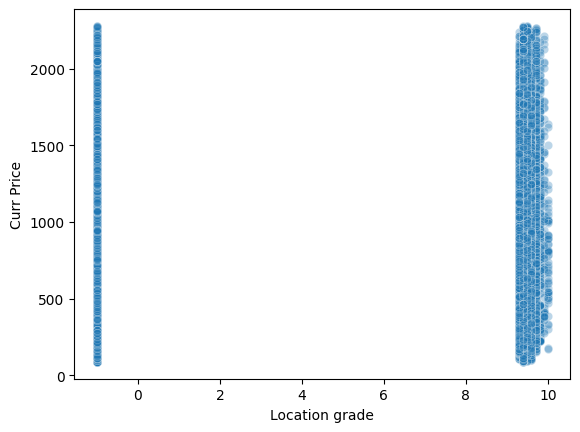

In [96]:
#without changes
sns.scatterplot(data = booking_df , x= 'Location grade' ,y = "Curr Price" ,alpha=0.3)


                Curr Price  Location grade
Curr Price        1.000000        0.113646
Location grade    0.113646        1.000000


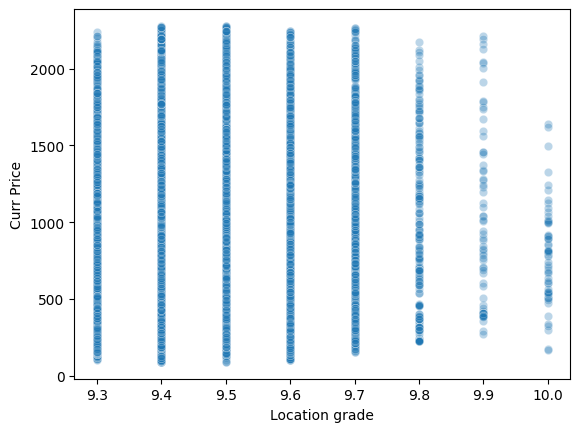

In [97]:
#drop None
df_test_location = booking_df[['Curr Price', 'Location grade']]
df_test_location = df_test_location[df_test_location['Location grade'] != -1]
sns.scatterplot(data = df_test_location , x= 'Location grade' ,y = "Curr Price" ,alpha=0.3)
print(df_test_location.corr())


<Axes: xlabel='Location grade', ylabel='Count'>

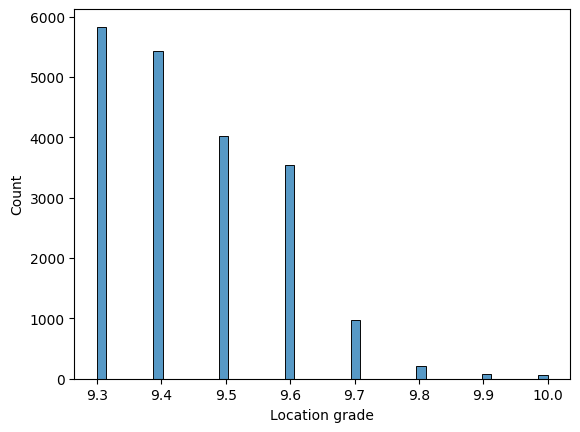

In [98]:
sns.histplot(data = df_test_location , x= 'Location grade')
    

                Curr Price  Location grade
Curr Price        1.000000        0.080394
Location grade    0.080394        1.000000
Distance from center mean: true  - false =  76.15588561588322


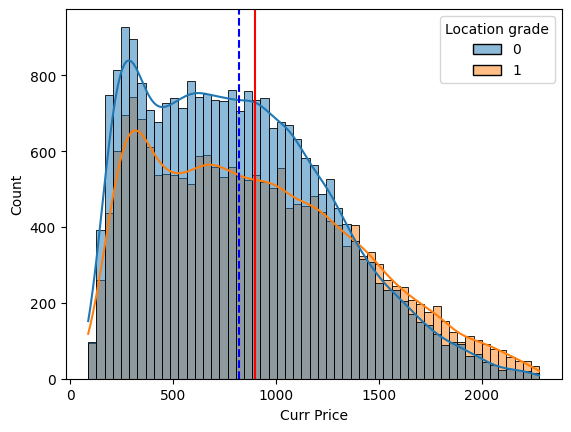

In [99]:
#change the column from numeric to binery
df_test_location2 = booking_df[['Curr Price', 'Location grade']]
df_test_location2['Location grade'] = df_test_location2['Location grade'].apply(lambda x: 0 if x ==-1 else 1)
sns.histplot(data=df_test_location2,x='Curr Price',hue = 'Location grade' ,kde =True)
print(df_test_location2.corr())
mean_1 =df_test_location2.loc[df_test_location2['Location grade']==1, "Curr Price"].mean()
plt.axvline(mean_1,c = 'r' , ls = '-')
mean_0 =df_test_location2.loc[df_test_location2['Location grade']==0, "Curr Price"].mean()
plt.axvline(mean_0,c = 'b' , ls = '--' )
print(col ,"mean: true  - false = " ,mean_1-mean_0 )

ראינו כי כשניסינו לשמור על המשתנה רציף על ידי הורדת עמודות התוצאות לא היו טובות
וכאשר ניסינו להפוך את העמודה לבינארית התוצאות היו טובות יותר ולכן נשנה את העמודה לבינארית

In [100]:
booking_df['Location grade'] = booking_df['Location grade'].apply(lambda x: 0 if x ==-1 else 1)
booking_df


Snapshot  Index                                         Hotel Name  TTT  \
0       Monday      1                 Margaritaville Resort Times Square    1   
1       Monday      2                          33 Seaport Hotel New York    1   
2       Monday      3                                The Belvedere Hotel    1   
3       Monday      4                                     CIVILIAN Hotel    1   
4       Monday      5                    The Cloud One New York-Downtown    1   
...        ...    ...                                                ...  ...   
44995   Friday     96      Aloft Manhattan Downtown - Financial District   30   
44996   Friday     97  Hampton Inn Manhattan/Downtown- Financial Dist...   30   
44997   Friday     98                                     Leon Hotel LES   30   
44998   Friday     99                                            SoHo 54   30   
44999   Friday    100                          New York Marriott Marquis   30   

       LOS  Grade  Num of Reviews  Curr Price  Original Price  \
0        1    8.8            1369      210.25          210.25   
1        1    8.6             284      293.57          293.57   
2        1    8.0            3644      142.59          142.59   
3        1    8.5            1172      214.45          214.45   
4        1    8.2             518      173.35          173.35   
...    ...    ...             ...         ...             ...   
44995    5    7.5            1106     1073.90         1073.90   
44996    5    7.6             658     1246.69         1246.69   
44997    5    8.1            1309     1509.22         1886.67   
44998    5    6.9            1562     1073.62         1192.73   
44999    5    8.2            1712     1989.28         1989.28   

       Distance from center                                    Type of room  \
0                      1500                             Standard Queen Room   
1                      6900                         Superior Courtyard King   
2                       900                              Standard King Room   
3                       900                                     Double Room   
4                      7000                              Standard King Room   
...                     ...                                             ...   
44995                  6800                             Guest room, 1 Queen   
44996                  7700                                      Queen Room   
44997                  5900                             Superior Queen Room   
44998                  5300                                       SoHo King   
44999                  1100  Renovated Deluxe, Guest room, 1 King, Sofa bed   

       Location grade  Free Cancellation  No prepayment needed  \
0                   1                  0                     0   
1                   0                  0                     0   
2                   1                  0                     0   
3                   1                  0                     0   
4                   0                  1                     1   
...               ...                ...                   ...   
44995               0                  1                     0   
44996               0                  1                     1   
44997               0                  1                     1   
44998               0                  1                     1   
44999               1                  0                     0   

       Breakfast included  Cancel Later  Percent of discount  Friday  Monday  \
0                       0             0                  0.0       0       1   
1                       0             0                  0.0       0       1   
2                       0             0                  0.0       0       1   
3                       0             0                  0.0       0       1   
4                       0             1                  0.0       0       1   
...                   ...     

<Axes: xlabel='Percent of discount', ylabel='Count'>

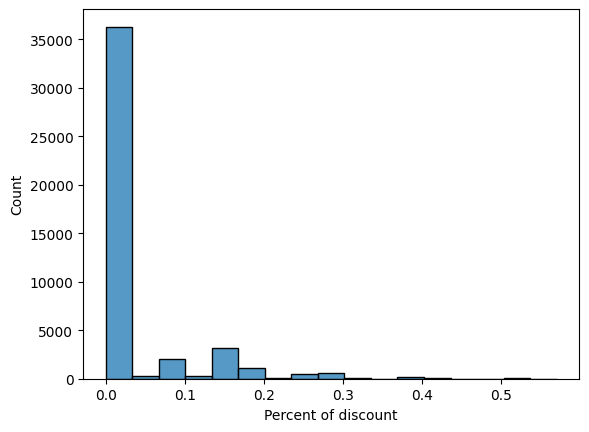

In [101]:
sns.histplot(data = booking_df, x = 'Percent of discount')

כצפוי לרוב המלונות אין הנחהת לכן נשנה את העמודה לבינארית - אם יש הנחה או אין

In [102]:
booking_df['Discount'] = booking_df['Percent of discount'].apply(lambda x : 1 if x != 0 else 0)
booking_df.drop(['Percent of discount'], axis = 1, inplace=True)
booking_df.head()

Snapshot  Index                          Hotel Name  TTT  LOS  Grade  \
0   Monday      1  Margaritaville Resort Times Square    1    1    8.8   
1   Monday      2           33 Seaport Hotel New York    1    1    8.6   
2   Monday      3                 The Belvedere Hotel    1    1    8.0   
3   Monday      4                      CIVILIAN Hotel    1    1    8.5   
4   Monday      5     The Cloud One New York-Downtown    1    1    8.2   

   Num of Reviews  Curr Price  Original Price  Distance from center  \
0            1369      210.25          210.25                  1500   
1             284      293.57          293.57                  6900   
2            3644      142.59          142.59                   900   
3            1172      214.45          214.45                   900   
4             518      173.35          173.35                  7000   

              Type of room  Location grade  Free Cancellation  \
0      Standard Queen Room               1                  0   
1  Superior Courtyard King               0                  0   
2       Standard King Room               1                  0   
3              Double Room               1                  0   
4       Standard King Room               0                  1   

   No prepayment needed  Breakfast included  Cancel Later  Friday  Monday  \
0                     0                   0             0       0       1   
1                     0                   0             0       0       1   
2                     0                   0             0       0       1   
3                     0                   0             0       0       1   
4                     1                   0             1       0       1   

   Wednesday  Discount  
0          0         0  
1          0         0  
2          0         0  
3          0         0  
4          0         0

<Axes: >

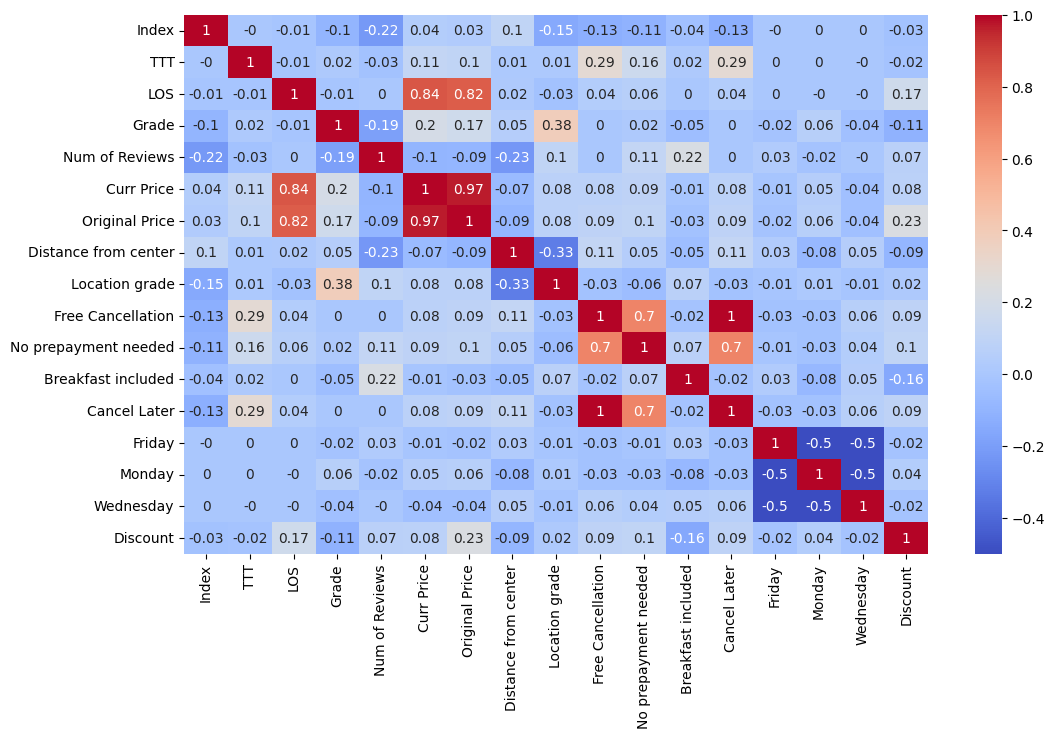

In [103]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(booking_df.corr().round(2), annot=True, ax=ax, cmap='coolwarm')

In [104]:
booking_df.corr()['Curr Price'].nlargest(10)

Curr Price              1.000000
Original Price          0.973376
LOS                     0.835752
Grade                   0.201261
TTT                     0.106650
No prepayment needed    0.087615
Free Cancellation       0.082993
Cancel Later            0.082993
Discount                0.080812
Location grade          0.080394
Name: Curr Price, dtype: float64

ניתן לראות שהמשתנה של הציון קורלטיבי יחסית לשאר עם המחיר ולכן שווה לדאוג שהחלוקה לאימון ולמידה יהיו ביחס שווה

<Axes: xlabel='LOS', ylabel='Curr Price'>

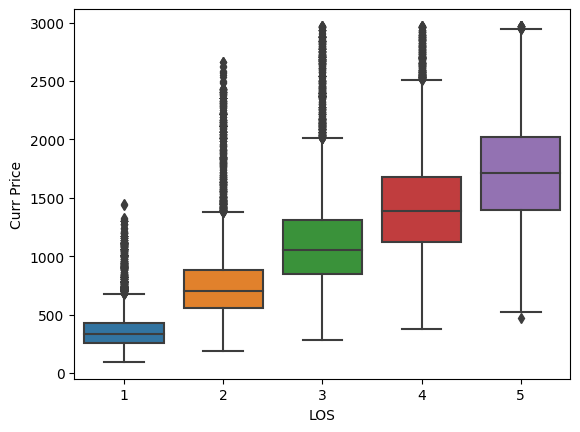

In [168]:
sns.boxplot(data = expedia_df, x = 'LOS', y = 'Curr Price')

In [169]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(booking_df, booking_df["LOS"]):
    strat_train_set = booking_df.iloc[train_index]
    strat_test_set = booking_df.iloc[test_index]

In [170]:
strat_test_set["LOS"].value_counts() / len(strat_test_set)


2    0.202035
1    0.202035
3    0.201736
4    0.200165
5    0.194029
Name: LOS, dtype: float64

In [171]:
booking_df["LOS"].value_counts() / len(booking_df)

1    0.202047
2    0.202047
3    0.201733
4    0.200117
5    0.194055
Name: LOS, dtype: float64

In [111]:
expedia_df.head(5)

Snapshot  Index                         Hotel Name  TTT  LOS  Grade  \
0   Monday      1                        Hotel 32 32    1    1    8.0   
1   Monday      2  Sonesta Simply Suites Jersey City    1    1    8.4   
2   Monday      3                 Park Lane New York    1    1    8.8   
3   Monday      4                       Arlo Midtown    1    1    9.2   
4   Monday      5      PUBLIC, an Ian Schrager hotel    1    1    8.0   

   Num of Reviews  Curr Price  Original Price  Is refundable  Late payment  \
0          1296.0       303.8           393.4              0             0   
1          1002.0       237.2           237.2              1             0   
2           305.0       490.7           538.8              0             0   
3          3123.0       358.5           358.5              1             0   
4          1465.0       467.8           467.8              0             0   

   Extras included  Option Member  Friday  Monday  Wednesday  Discount  
0                0              0       0       1          0         1  
1                0              0       0       1          0         0  
2                0              0       0       1          0         1  
3                0              1       0       1          0         0  
4                0              1       0       1          0         0

In [112]:
booking_df.head(5)

Snapshot  Index                          Hotel Name  TTT  LOS  Grade  \
0   Monday      1  Margaritaville Resort Times Square    1    1    8.8   
1   Monday      2           33 Seaport Hotel New York    1    1    8.6   
2   Monday      3                 The Belvedere Hotel    1    1    8.0   
3   Monday      4                      CIVILIAN Hotel    1    1    8.5   
4   Monday      5     The Cloud One New York-Downtown    1    1    8.2   

   Num of Reviews  Curr Price  Original Price  Distance from center  \
0            1369      210.25          210.25                  1500   
1             284      293.57          293.57                  6900   
2            3644      142.59          142.59                   900   
3            1172      214.45          214.45                   900   
4             518      173.35          173.35                  7000   

              Type of room  Location grade  Free Cancellation  \
0      Standard Queen Room               1                  0   
1  Superior Courtyard King               0                  0   
2       Standard King Room               1                  0   
3              Double Room               1                  0   
4       Standard King Room               0                  1   

   No prepayment needed  Breakfast included  Cancel Later  Friday  Monday  \
0                     0                   0             0       0       1   
1                     0                   0             0       0       1   
2                     0                   0             0       0       1   
3                     0                   0             0       0       1   
4                     1                   0             1       0       1   

   Wednesday  Discount  
0          0         0  
1          0         0  
2          0         0  
3          0         0  
4          0         0

In [113]:
#just for the first time
expedia_df.to_csv('expedia_df_prepeared.csv', index=False, header=True)
booking_df.to_csv('booking_df_prepeared.csv', index=False, header=True)


 # Split the data

In [114]:
expedia_df_prepeared = pd.read_csv('expedia_df_prepeared.csv')
booking_df_prepeared = pd.read_csv('booking_df_prepeared.csv')

In [115]:
X_full_data_train_expedia , y_train_expedia, X_full_data_test_expedia, y_test_expedia = strat_split(expedia_df_prepeared, 0.3, 42)
X_full_data_train_booking , y_train_booking, X_full_data_test_booking, y_test_booking = strat_split(booking_df_prepeared, 0.3, 42)

# Predicting the price

## Linear Regression

## Desicion Tree

 ### Expedia

In [116]:
columns_to_drop = ['Hotel Name', 'Original Price', 'Snapshot']
X_train_expedia = X_full_data_train_expedia.drop(columns_to_drop, axis=1)
X_test_expedia = X_full_data_test_expedia.drop(columns_to_drop, axis=1)

#### Run Model

In [117]:
Tree_Expedia = Tree_hyperparameters(X_train_expedia, y_train_expedia)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=best;, score=0.477 total time=   0.0s
[CV 2/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=best;, score=0.476 total time=   0.0s
[CV 3/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=best;, score=0.476 total time=   0.0s
[CV 4/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=best;, score=0.462 total time=   0.0s
[CV 5/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=best;, score=0.482 total time=   0.0s
[CV 1/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=random;, score=0.345 total time=   0.0s
[CV 2/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=random;, score=0.268 total time=   0.0s
[CV 3/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=random;, score=0.348 total time=   0.0s
[CV 4/5] END max_depth=2, max_leaf_nodes=2

In [118]:
Tree_Expedia.fit(X_train_expedia, y_train_expedia)
metrics_f(Tree_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

Train MSE: 93810.22861023004
Test MSE: 92657.54545447615
Train RMSE: 306.28455496519905
Test RMSE: 304.39701945728075
Train MAE: 217.9514186963221
Test MAE: 218.68722731947315
Train R2: 0.753695246089054
Test R2: 0.7514951550616992


In [119]:
joblib.dump(Tree_Expedia, "Tree_Expedia.pkl")

['Tree_Expedia.pkl']

#### Analyze Results

In [120]:
Tree_Expedia = joblib.load("Tree_Expedia.pkl")

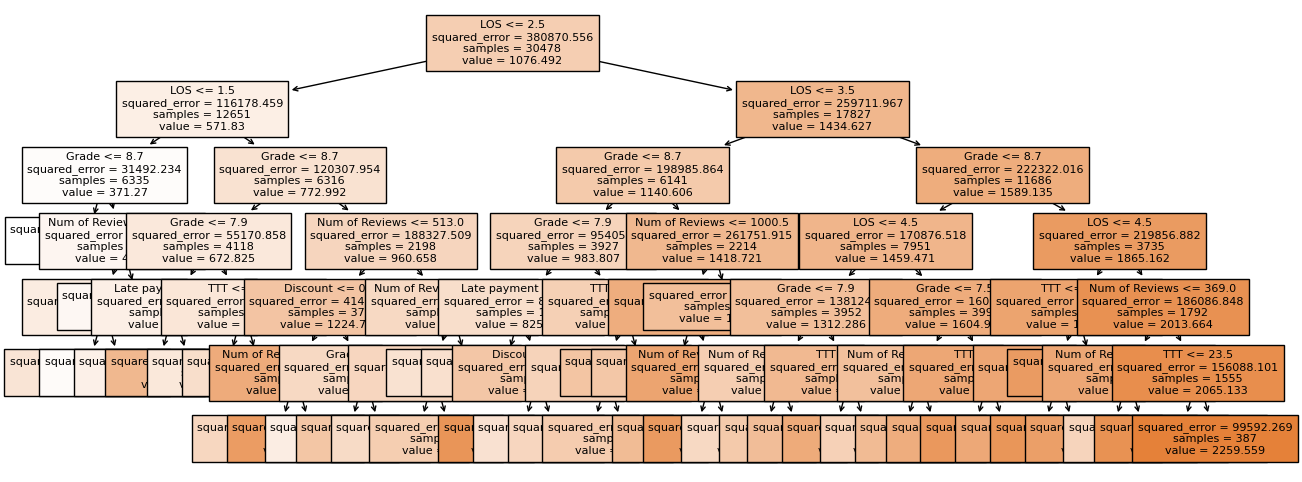

In [121]:
fig, axes = plt.subplots(1,1, figsize=(15,6))
tree.plot_tree(Tree_Expedia, feature_names = list(X_train_expedia.columns), filled = True,fontsize=8)
plt.show()

In [122]:
best_params = Tree_Expedia.get_params()

In [123]:
Tree_Expedia.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 40,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [124]:
metrics_f(Tree_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

Train MSE: 93810.22861023004
Test MSE: 92657.54545447615
Train RMSE: 306.28455496519905
Test RMSE: 304.39701945728075
Train MAE: 217.9514186963221
Test MAE: 218.68722731947315
Train R2: 0.753695246089054
Test R2: 0.7514951550616992


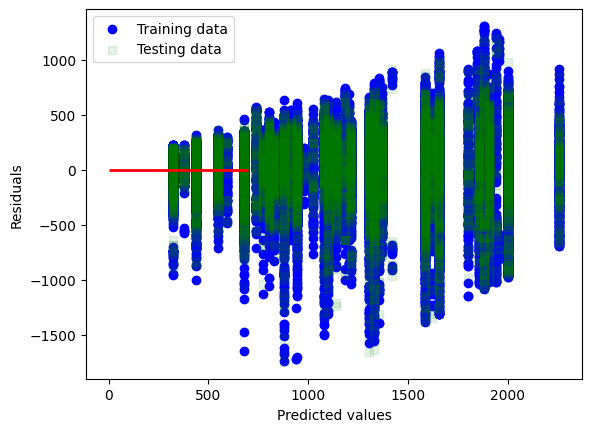

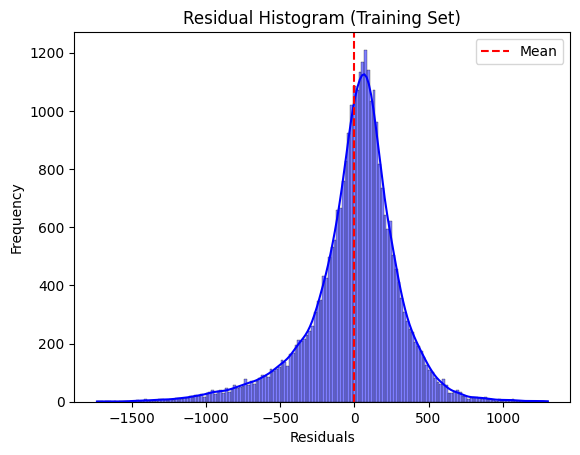

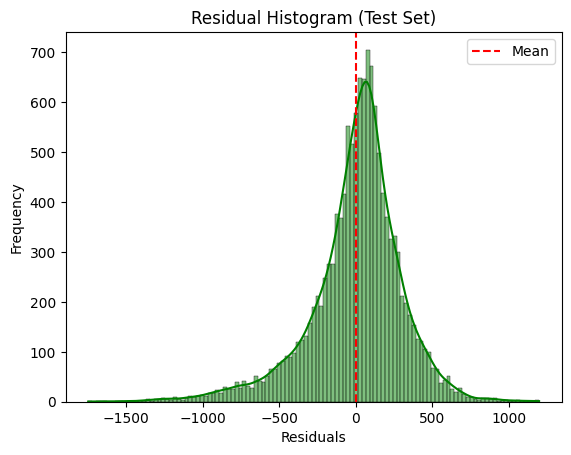

In [125]:
residual_plot(Tree_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

#### Feature Importances

In [126]:
feature_importance = {}
for i, feature in enumerate(X_train_expedia.columns):
    feature_importance[feature] = Tree_Expedia.feature_importances_[i]
sorted_feature_importances_dict = sorted(feature_importance.items(), key=lambda x:x[1], reverse=True)

for i in sorted_feature_importances_dict:
    print(i)

('LOS', 0.8086577386915699)
('Grade', 0.13011360039624667)
('Num of Reviews', 0.026934202115885632)
('TTT', 0.01986123776561948)
('Discount', 0.008843139980058983)
('Late payment', 0.0028434262507344215)
('Monday', 0.0027466547998850448)
('Index', 0.0)
('Is refundable', 0.0)
('Extras included', 0.0)
('Option Member', 0.0)
('Friday', 0.0)
('Wednesday', 0.0)


In [127]:
feature_importance_with_drop(DecisionTreeRegressor(**best_params), X_train_expedia, y_train_expedia, X_test_expedia, y_test_expedia)

('LOS', 0.7833889746268897)
('Grade', 0.33116001697750397)
('Num of Reviews', 0.26207138945687225)
('TTT', 0.25303668385402334)
('Discount', 0.25156565134051423)
('Late payment', 0.25118464532663043)
('Monday', 0.24857763541181754)
('Extras included', 0.24850484493830094)
('Index', 0.24850484493830083)
('Is refundable', 0.24850484493830083)
('Option Member', 0.24850484493830083)
('Friday', 0.24850484493830083)
('Wednesday', 0.24850484493830083)


#### Standartize continous columns

In [128]:
X_train_expedia_standartize = X_train_expedia.copy()  
standartize_cols = ['Index', 'TTT', 'LOS', 'Grade', 'Num of Reviews']
X_train_expedia_standartize[standartize_cols] = standartize.fit_transform(X_train_expedia[standartize_cols])
X_test_expedia_standartize = X_test_expedia.copy() 
X_test_expedia_standartize[standartize_cols] = standartize.fit_transform(X_test_expedia[standartize_cols])

In [129]:
Tree_Expedia_standartize = DecisionTreeRegressor(**best_params)

In [130]:
Tree_Expedia_standartize.fit(X_train_expedia_standartize, y_train_expedia)

DecisionTreeRegressor(max_depth=6, max_leaf_nodes=40, min_samples_leaf=10)

In [131]:
metrics_f(Tree_Expedia_standartize , X_train_expedia_standartize ,X_test_expedia_standartize, y_train_expedia ,y_test_expedia)

Train MSE: 93810.22861023004
Test MSE: 95426.60385719872
Train RMSE: 306.28455496519905
Test RMSE: 308.9119678115413
Train MAE: 217.951418696322
Test MAE: 219.68331192023484
Train R2: 0.753695246089054
Test R2: 0.7440686208747802


#### Add checkin columns

In [132]:
expedia_df_prepeared_more_features = Checkin_day(expedia_df_prepeared)

<Axes: xlabel='Checkin Day of week'>

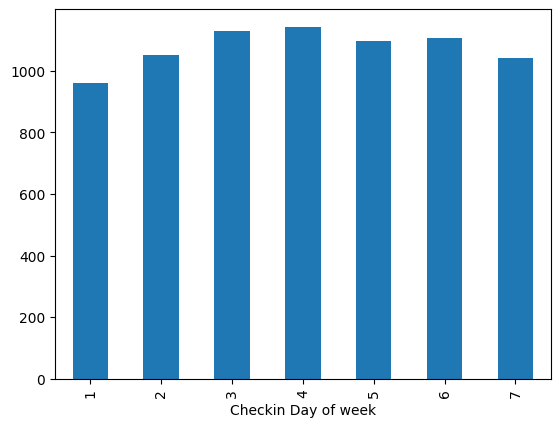

In [133]:
expedia_df_prepeared_more_features.groupby('Checkin Day of week')['Curr Price'].mean().plot(kind='bar')

In [134]:
X_train_expedia_more_features = Checkin_day(X_train_expedia)
X_test_expedia_more_features = Checkin_day(X_test_expedia)

In [135]:
Tree_Expedia_more_features = DecisionTreeRegressor(**best_params)
Tree_Expedia_more_features.fit(X_train_expedia_more_features, y_train_expedia)
metrics_f(Tree_Expedia_more_features , X_train_expedia_more_features ,X_test_expedia_more_features, y_train_expedia ,y_test_expedia)

Train MSE: 93810.22861023004
Test MSE: 92657.54545447613
Train RMSE: 306.28455496519905
Test RMSE: 304.3970194572807
Train MAE: 217.9514186963221
Test MAE: 218.68722731947315
Train R2: 0.753695246089054
Test R2: 0.7514951550616992


### Booking

In [136]:
columns_to_drop = ['Hotel Name', 'Original Price', 'Snapshot', 'Type of room']
X_train_booking = X_full_data_train_booking.drop(columns_to_drop, axis=1)
X_test_booking = X_full_data_test_booking.drop(columns_to_drop, axis=1)

#### Run Model

In [137]:
Tree_Booking = Tree_hyperparameters(X_train_booking, y_train_booking)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV 1/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=best;, score=0.532 total time=   0.0s
[CV 2/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=best;, score=0.535 total time=   0.0s
[CV 3/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=best;, score=0.529 total time=   0.0s
[CV 4/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=best;, score=0.532 total time=   0.0s
[CV 5/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=best;, score=0.537 total time=   0.0s
[CV 1/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=random;, score=0.321 total time=   0.0s
[CV 2/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=random;, score=0.535 total time=   0.0s
[CV 3/5] END max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, splitter=random;, score=0.511 total time=   0.0s
[CV 4/5] END max_depth=2, max_leaf_nodes=2

In [138]:
Tree_Booking.fit(X_train_booking, y_train_booking)
metrics_f(Tree_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

Train MSE: 44439.8865383727
Test MSE: 44991.5669079461
Train RMSE: 210.8077003773171
Test RMSE: 212.11215643603762
Train MAE: 153.45623416414227
Test MAE: 155.53325224870716
Train R2: 0.8009535819695534
Test R2: 0.7954572419368886


In [139]:
joblib.dump(Tree_Booking, "Tree_Booking.pkl")

['Tree_Booking.pkl']

#### Analyze Results

In [140]:
Tree_Booking = joblib.load("Tree_Booking.pkl")

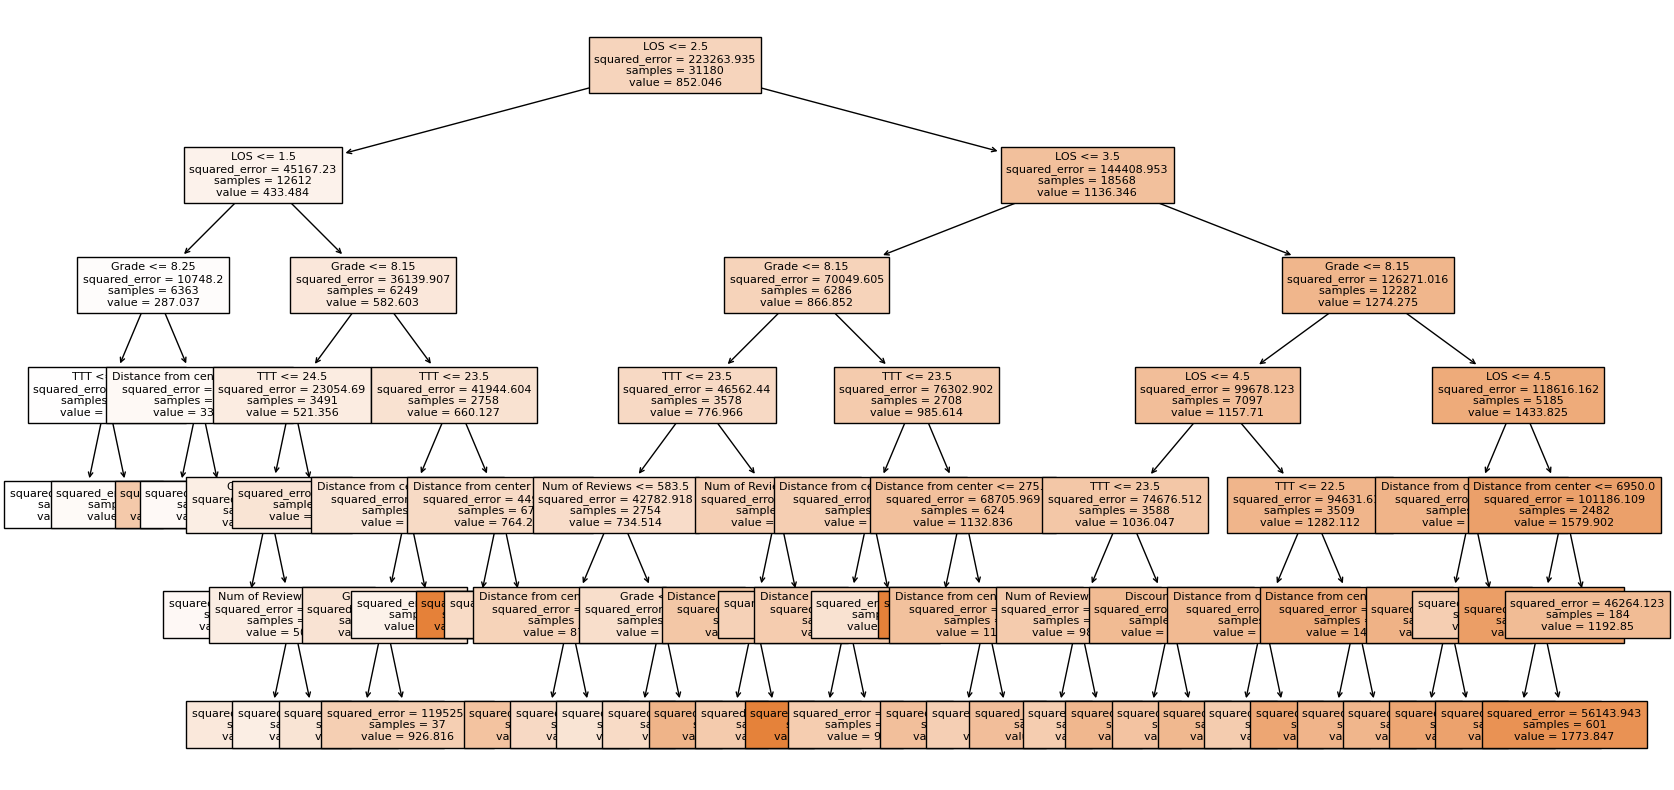

In [141]:
fig, axes = plt.subplots(1,1, figsize=(20,10))
tree.plot_tree(Tree_Booking, feature_names = list(X_train_booking.columns), filled = True,fontsize=8)
plt.show()

In [142]:
best_params = Tree_Booking.get_params()

In [143]:
Tree_Booking.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 40,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [144]:
metrics_f(Tree_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

Train MSE: 44439.8865383727
Test MSE: 44991.5669079461
Train RMSE: 210.8077003773171
Test RMSE: 212.11215643603762
Train MAE: 153.45623416414227
Test MAE: 155.53325224870716
Train R2: 0.8009535819695534
Test R2: 0.7954572419368886


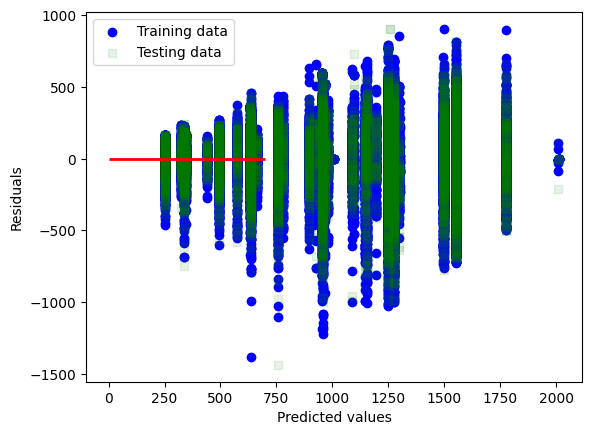

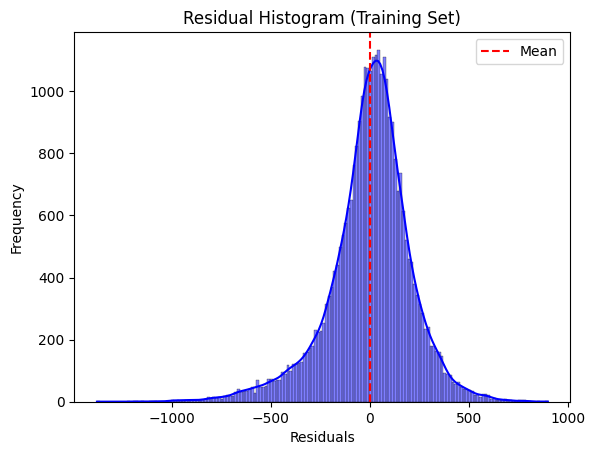

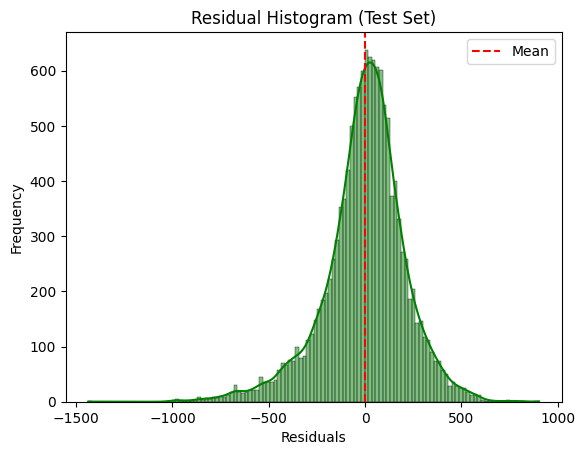

In [145]:
residual_plot(Tree_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

#### Feature Importances

In [146]:
feature_importance = {}
for i, feature in enumerate(X_train_booking.columns):
    feature_importance[feature] = Tree_Booking.feature_importances_[i]
sorted_feature_importances_dict = sorted(feature_importance.items(), key=lambda x:x[1], reverse=True)

for i in sorted_feature_importances_dict:
    print(i)

('LOS', 0.8761101111071955)
('Grade', 0.06242171580704967)
('TTT', 0.0319383521548223)
('Distance from center', 0.023956481901390044)
('Num of Reviews', 0.004627705678685475)
('Discount', 0.0009456333508571504)
('Index', 0.0)
('Location grade', 0.0)
('Free Cancellation', 0.0)
('No prepayment needed', 0.0)
('Breakfast included', 0.0)
('Cancel Later', 0.0)
('Friday', 0.0)
('Monday', 0.0)
('Wednesday', 0.0)


In [147]:
feature_importance_with_drop(DecisionTreeRegressor(**best_params), X_train_booking, y_train_booking, X_test_booking, y_test_booking)

('LOS', 0.8627762256643791)
('Grade', 0.23813518989373683)
('Distance from center', 0.2141211319363936)
('TTT', 0.21302705281645595)
('Num of Reviews', 0.20583114436032623)
('Discount', 0.20467995368168002)
('Index', 0.2045427580631114)
('Location grade', 0.2045427580631114)
('Free Cancellation', 0.2045427580631114)
('No prepayment needed', 0.2045427580631114)
('Breakfast included', 0.2045427580631114)
('Cancel Later', 0.2045427580631114)
('Friday', 0.2045427580631114)
('Monday', 0.2045427580631114)
('Wednesday', 0.2045427580631114)


#### Standartize continous columns

In [148]:
X_train_booking_standartize = X_train_booking.copy()  
standartize_cols = ['Index', 'TTT', 'LOS', 'Grade', 'Num of Reviews']
X_train_booking_standartize[standartize_cols] = standartize.fit_transform(X_train_booking[standartize_cols])
X_test_booking_standartize = X_test_booking.copy() 
X_test_booking_standartize[standartize_cols] = standartize.fit_transform(X_test_booking[standartize_cols])

In [149]:
Tree_Booking_standartize = DecisionTreeRegressor(**best_params)

In [150]:
Tree_Booking_standartize.fit(X_train_booking_standartize, y_train_booking)

DecisionTreeRegressor(max_depth=6, max_leaf_nodes=40)

In [151]:
metrics_f(Tree_Booking_standartize , X_train_booking_standartize ,X_test_booking_standartize, y_train_booking ,y_test_booking)

Train MSE: 44439.8865383727
Test MSE: 44990.643732165176
Train RMSE: 210.8077003773171
Test RMSE: 212.1099802747744
Train MAE: 153.45623416414222
Test MAE: 155.54761375568032
Train R2: 0.8009535819695534
Test R2: 0.7954614389216434


#### Add checkin columns

In [152]:
booking_df_prepeared_more_features = Checkin_day(booking_df_prepeared)

<Axes: xlabel='Checkin Day of week'>

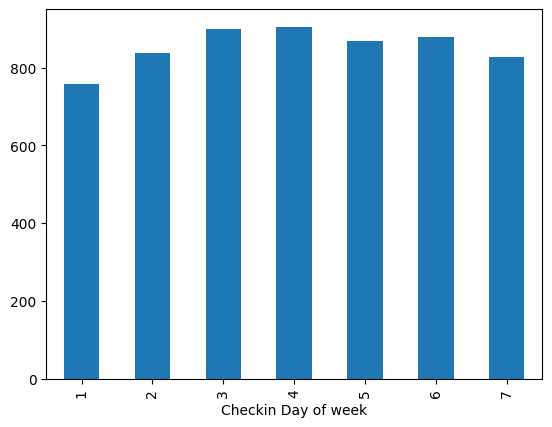

In [153]:
booking_df_prepeared_more_features.groupby('Checkin Day of week')['Curr Price'].mean().plot(kind='bar')

In [154]:
X_train_booking_more_features = Checkin_day(X_train_booking)
X_test_booking_more_features = Checkin_day(X_test_booking)

In [155]:
Tree_Booking_more_features = DecisionTreeRegressor(**best_params)
Tree_Booking_more_features.fit(X_train_booking_more_features, y_train_booking)
metrics_f(Tree_Booking_more_features , X_train_booking_more_features ,X_test_booking_more_features, y_train_booking ,y_test_booking)

Train MSE: 44237.84262983697
Test MSE: 44731.478326722055
Train RMSE: 210.3279406779731
Test RMSE: 211.49817570542317
Train MAE: 152.44322593704973
Test MAE: 154.2116919216882
Train R2: 0.8018585373916196
Test R2: 0.7966396687648569


In [156]:
roy_zain.head()

NameError: name 'roy_zain' is not defined

## Gaussian Proccess

### Expedia

In [ ]:
expedia_df_prepeared_sample = expedia_df_prepeared.sample(frac=0.4, random_state=1)
print(expedia_df_prepeared_sample.shape)
expedia_df_prepeared_sample.head()

(16844, 17)


Snapshot  Index                                        Hotel Name  TTT  \
5186    Monday     12                       Park Central Hotel New York   12   
34298   Friday     13              Sheraton New York Times Square Hotel   14   
33270   Friday     52  Doubletree by Hilton New York Times Square South   12   
31452   Friday     90                  RIU Plaza Manhattan Times Square    8   
40957   Friday     60                          The Hotel @ Fifth Avenue   28   

       LOS  Grade  Num of Reviews  Curr Price  Original Price  Is refundable  \
5186     4    8.0          1908.0       325.7           374.6              1   
34298    3    8.0          1228.0       347.3           347.3              1   
33270    2    8.4          2127.0       273.2           273.2              0   
31452    3    9.0          1896.0       350.6           350.6              1   
40957    3    7.4          1002.0       351.4           387.9              1   

       Late payment  Extras included  Option Member  Friday  Monday  \
5186              0                0              1       0       1   
34298             0                0              0       1       0   
33270             0                0              1       1       0   
31452             0                0              0       1       0   
40957             0                0              1       1       0   

       Wednesday  Discount  
5186           0         1  
34298          0         0  
33270          0         0  
31452          0         0  
40957          0         1

In [ ]:

X_full_data_train_expedia , y_train_expedia, X_full_data_test_expedia, y_test_expedia = strat_split(expedia_df_prepeared_sample, 0.3, 42)

In [ ]:
columns_to_keep = ['Index', 'TTT', 'LOS', 'Grade', 'Num of Reviews']
X_train_expedia = X_full_data_train_expedia[columns_to_keep]
X_test_expedia = X_full_data_test_expedia[columns_to_keep]

In [ ]:
kernel =Sum(ConstantKernel(1.0, (1e-3, 1e3))*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
                ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)))
kernel = ConstantKernel(1.0, (1e-3, 1e3))*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train_expedia, y_train_expedia)
metrics_f(gp , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)


#### Run Model

In [ ]:
GP_Expedia = gp_hyperparameters(X_train_expedia, y_train_expedia)

Fitting 4 folds for each of 243 candidates, totalling 972 fits
[CV 1/4] END alpha=0.01, kernel__k1__k1__constant_value=0.1, kernel__k1__k2__length_scale=0.1, kernel__k2__length_scale=0.1, kernel__k2__periodicity=0.1;, score=nan total time= 4.5min


KeyboardInterrupt: 

In [ ]:
GP_Expedia.fit(X_train_expedia, y_train_expedia)
metrics_f(GP_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

Train MSE: 8.098184681495832
Test MSE: 935.2399325278204
Train RMSE: 2.8457309573281577
Test RMSE: 30.581692767533657
Train MAE: 1.7355273456446014
Test MAE: 19.318957192833256
Train R2: 0.9992857043314801
Test R2: 0.9181606162044949


In [ ]:
joblib.dump(GP_Expedia, "GP_Expedia.pkl")

['XGB_Expedia.pkl']

### Booking

In [ ]:
columns_to_keep = ['Index', 'TTT', 'LOS', 'Grade', 'Num of Reviews', 'Distance from center']
X_train_booking = X_full_data_train_booking[columns_to_keep]
X_test_booking = X_full_data_test_booking[columns_to_keep]

#### Run Model

In [ ]:
GP_Booking = gp_hyperparameters(X_train_booking, y_train_booking)

In [ ]:
XGB_Booking.fit(X_train_booking, y_train_booking)
metrics_f(XGB_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

## KNN

 ### Expedia

In [ ]:
columns_to_drop = ['Hotel Name', 'Original Price', 'Snapshot']
X_train_expedia = X_full_data_train_expedia.drop(columns_to_drop, axis=1)
X_test_expedia = X_full_data_test_expedia.drop(columns_to_drop, axis=1)

#### Run model

In [ ]:
#KNN_Expedia = knn_hyperparameter(X_train_expedia, y_train_expedia)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
[CV 1/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=uniform;, score=0.612 total time=   0.1s
[CV 2/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=uniform;, score=0.603 total time=   0.2s
[CV 3/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=uniform;, score=0.599 total time=   0.2s
[CV 4/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=uniform;, score=0.580 total time=   0.1s
[CV 5/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=uniform;, score=0.584 total time=   0.1s
[CV 1/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=distance;, score=0.634 total time=   0.1s
[CV 2/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=distance;, score=0.620 total time=   0.1s
[CV 3/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=distance;, score=0.617 total time=   0.1s
[CV 4/5] END leaf_siz

In [ ]:
KNN_Expedia.fit(X_train_expedia, y_train_expedia)
metrics_f(KNN_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

Train MSE: 0.0
Test MSE: 3165.9534223222004
Train RMSE: 0.0
Test RMSE: 56.26680568792048
Train MAE: 0.0
Test MAE: 37.43254901567359
Train R2: 1.0
Test R2: 0.7229591378676377


In [ ]:
joblib.dump(KNN_Expedia, "KNN_Expedia.pkl")

['KNN_Expedia.pkl']

#### Analyze Results

In [ ]:
KNN_Expedia = joblib.load("KNN_Expedia.pkl")

In [ ]:
best_params = KNN_Expedia.get_params()

In [ ]:
KNN_Expedia.get_params()

{'algorithm': 'auto',
 'leaf_size': 10,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 1,
 'weights': 'distance'}

In [ ]:
metrics_f(KNN_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

Train MSE: 0.0
Test MSE: 3165.9534223222004
Train RMSE: 0.0
Test RMSE: 56.26680568792048
Train MAE: 0.0
Test MAE: 37.43254901567359
Train R2: 1.0
Test R2: 0.7229591378676377


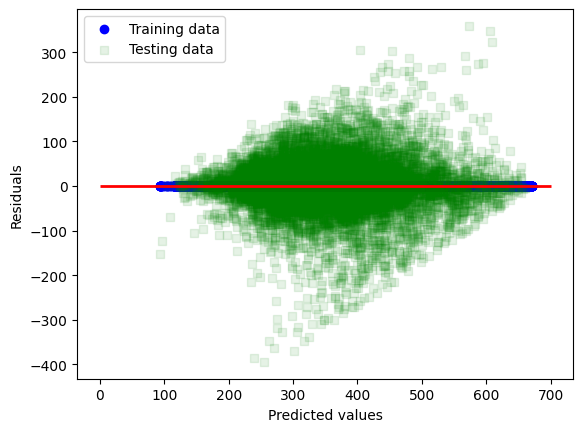

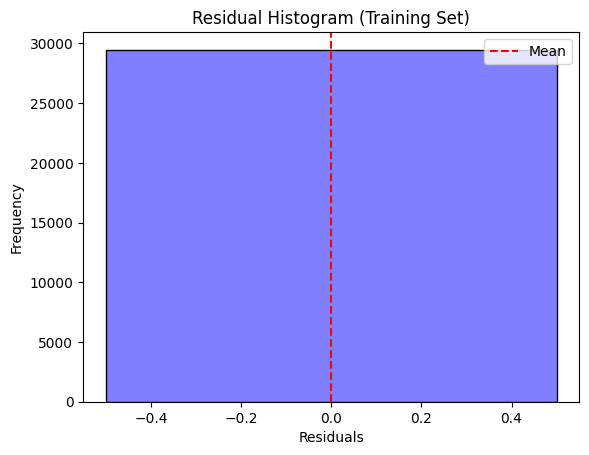

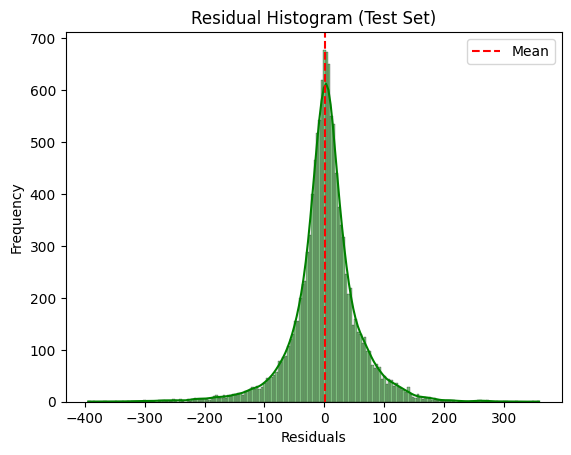

In [ ]:
residual_plot(KNN_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

#### Standartize continous columns

In [ ]:
X_train_expedia_standartize = X_train_expedia.copy()  
standartize_cols = ['Index', 'TTT', 'LOS', 'Grade', 'Num of Reviews']
X_train_expedia_standartize[standartize_cols] = standartize.fit_transform(X_train_expedia[standartize_cols])
X_test_expedia_standartize = X_test_expedia.copy() 
X_test_expedia_standartize[standartize_cols] = standartize.fit_transform(X_test_expedia[standartize_cols])

In [ ]:
KNN_Expedia_standartize = KNeighborsRegressor(**best_params)

In [ ]:
KNN_Expedia_standartize.fit(X_train_expedia_standartize, y_train_expedia)

KNeighborsRegressor(leaf_size=10, metric='manhattan', p=1, weights='distance')

In [ ]:
metrics_f(KNN_Expedia_standartize , X_train_expedia_standartize ,X_test_expedia_standartize, y_train_expedia ,y_test_expedia)

Train MSE: 0.0
Test MSE: 3175.001875922078
Train RMSE: 0.0
Test RMSE: 56.34715499403744
Train MAE: 0.0
Test MAE: 38.69401297483585
Train R2: 1.0
Test R2: 0.7221673411947618


#### Add checkin columns

In [ ]:
expedia_df_prepeared_more_features = Checkin_day(expedia_df_prepeared)

<Axes: xlabel='Checkin Day of week'>

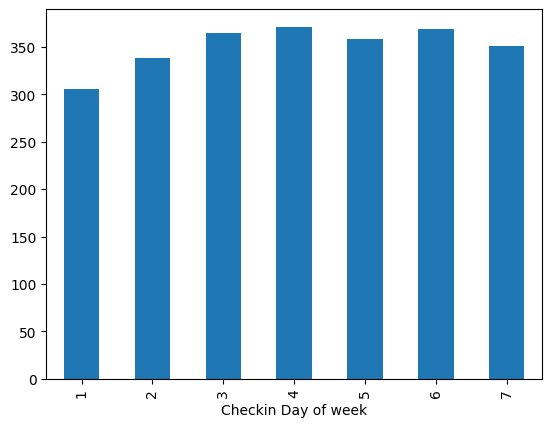

In [ ]:
expedia_df_prepeared_more_features.groupby('Checkin Day of week')['Curr Price'].mean().plot(kind='bar')

In [ ]:
X_train_expedia_more_features = Checkin_day(X_train_expedia)
X_test_expedia_more_features = Checkin_day(X_test_expedia)

In [ ]:
KNN_Expedia_more_features = KNeighborsRegressor(**best_params)
KNN_Expedia_more_features.fit(X_train_expedia_more_features, y_train_expedia)
metrics_f(KNN_Expedia_more_features , X_train_expedia_more_features ,X_test_expedia_more_features, y_train_expedia ,y_test_expedia)

Train MSE: 0.0
Test MSE: 3106.5883870800512
Train RMSE: 0.0
Test RMSE: 55.73677768834552
Train MAE: 0.0
Test MAE: 36.7316278754664
Train R2: 1.0
Test R2: 0.7281539523042758


### Booking

In [ ]:
booking_df_prepeared.head()

Snapshot  Index                          Hotel Name  TTT  LOS  Grade  \
0   Monday      1  Margaritaville Resort Times Square    1    1    8.8   
1   Monday      2           33 Seaport Hotel New York    1    1    8.6   
2   Monday      3                 The Belvedere Hotel    1    1    8.0   
3   Monday      4                      CIVILIAN Hotel    1    1    8.5   
4   Monday      5     The Cloud One New York-Downtown    1    1    8.2   

   Num of Reviews  Curr Price  Original Price  Distance from center  \
0            1369      210.25          210.25                  1500   
1             284      293.57          293.57                  6900   
2            3644      142.59          142.59                   900   
3            1172      214.45          214.45                   900   
4             518      173.35          173.35                  7000   

              Type of room  Location grade  Free Cancellation  \
0      Standard Queen Room               1                  0   
1  Superior Courtyard King               0                  0   
2       Standard King Room               1                  0   
3              Double Room               1                  0   
4       Standard King Room               0                  1   

   No prepayment needed  Breakfast included  Cancel Later  Friday  Monday  \
0                     0                   0             0       0       1   
1                     0                   0             0       0       1   
2                     0                   0             0       0       1   
3                     0                   0             0       0       1   
4                     1                   0             1       0       1   

   Wednesday  Discount  
0          0         0  
1          0         0  
2          0         0  
3          0         0  
4          0         0

In [ ]:
columns_to_drop = ['Hotel Name', 'Original Price', 'Snapshot', 'Type of room']
X_train_booking = X_full_data_train_booking.drop(columns_to_drop, axis=1)
X_test_booking = X_full_data_test_booking.drop(columns_to_drop, axis=1)

#### Run Model

In [ ]:
KNN_Booking = knn_hyperparameter(X_train_booking, y_train_booking)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
[CV 1/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=uniform;, score=0.698 total time=   0.2s
[CV 2/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=uniform;, score=0.691 total time=   0.1s
[CV 3/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=uniform;, score=0.709 total time=   0.2s
[CV 4/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=uniform;, score=0.700 total time=   0.2s
[CV 5/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=uniform;, score=0.709 total time=   0.2s
[CV 1/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=distance;, score=0.713 total time=   0.2s
[CV 2/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=distance;, score=0.705 total time=   0.2s
[CV 3/5] END leaf_size=10, metric=euclidean, n_neighbors=3, p=1, weights=distance;, score=0.721 total time=   0.1s
[CV 4/5] END leaf_siz

In [ ]:
KNN_Booking.fit(X_train_booking, y_train_booking)
metrics_f(KNN_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

Train MSE: 0.0
Test MSE: 1461.788214649566
Train RMSE: 0.0
Test RMSE: 38.233339046564666
Train MAE: 0.0
Test MAE: 27.361121860354505
Train R2: 1.0
Test R2: 0.7673481495019813


In [ ]:
joblib.dump(KNN_Booking, "KNN_Booking.pkl")

['KNN_Booking.pkl']

#### Analyze Results

In [ ]:
KNN_Booking = joblib.load("KNN_Booking.pkl")

In [ ]:
best_params = KNN_Booking.get_params()

In [ ]:
KNN_Booking.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 1,
 'weights': 'distance'}

In [ ]:
metrics_f(KNN_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

Train MSE: 0.0
Test MSE: 1461.788214649566
Train RMSE: 0.0
Test RMSE: 38.233339046564666
Train MAE: 0.0
Test MAE: 27.361121860354505
Train R2: 1.0
Test R2: 0.7673481495019813


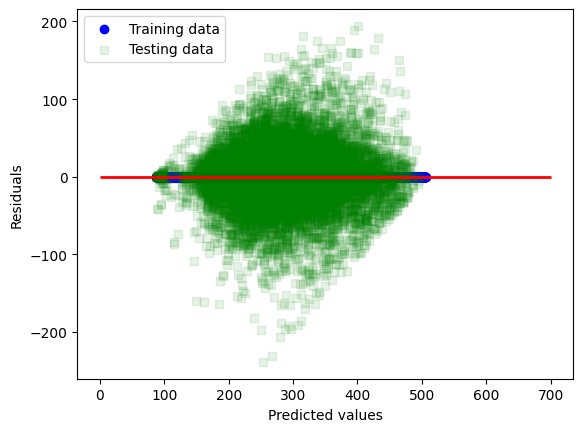

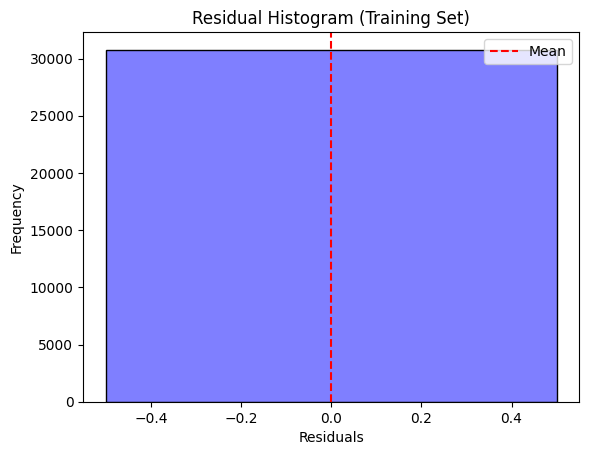

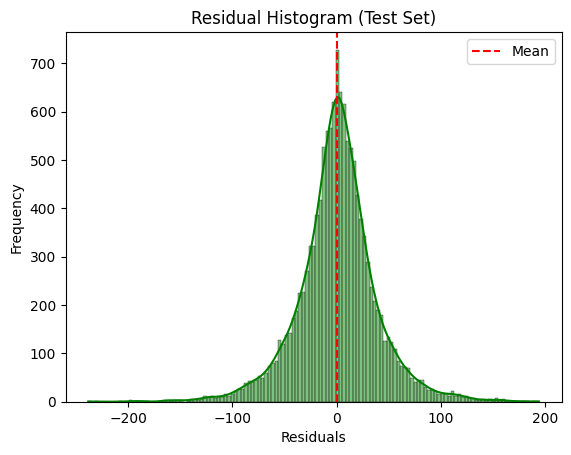

In [ ]:
residual_plot(KNN_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

#### Standartize continous columns

In [ ]:
X_train_booking_standartize = X_train_booking.copy()  
standartize_cols = ['Index', 'TTT', 'LOS', 'Grade', 'Num of Reviews','Distance from center']
X_train_booking_standartize[standartize_cols] = standartize.fit_transform(X_train_booking[standartize_cols])
X_test_booking_standartize = X_test_booking.copy() 
X_test_booking_standartize[standartize_cols] = standartize.fit_transform(X_test_booking[standartize_cols])

In [ ]:
KNN_Booking_standartize = KNeighborsRegressor(**best_params)

In [ ]:
KNN_Booking_standartize.fit(X_train_booking_standartize, y_train_booking)

KNeighborsRegressor(metric='manhattan', p=1, weights='distance')

In [ ]:
metrics_f(KNN_Booking_standartize , X_train_booking_standartize ,X_test_booking_standartize, y_train_booking ,y_test_booking)

Train MSE: 0.0
Test MSE: 1746.9514009095267
Train RMSE: 0.0
Test RMSE: 41.796547715206415
Train MAE: 0.0
Test MAE: 29.95272933955347
Train R2: 1.0
Test R2: 0.7219628178154787


#### Add checkin columns

In [ ]:
booking_df_prepeared_more_features = Checkin_day(booking_df_prepeared)

<Axes: xlabel='Checkin Day of week'>

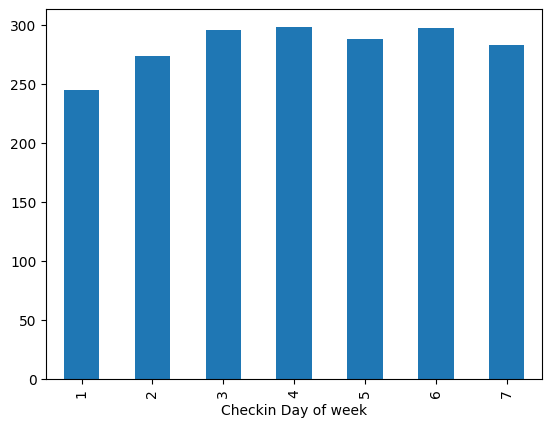

In [ ]:
booking_df_prepeared_more_features.groupby('Checkin Day of week')['Curr Price'].mean().plot(kind='bar')

In [ ]:
X_train_booking_more_features = Checkin_day(X_train_booking)
X_test_booking_more_features = Checkin_day(X_test_booking)

In [ ]:
KNN_Booking_more_features = KNeighborsRegressor(**best_params)
KNN_Booking_more_features.fit(X_train_booking_more_features, y_train_booking)
metrics_f(KNN_Booking_more_features , X_train_booking_more_features ,X_test_booking_more_features, y_train_booking ,y_test_booking)

Train MSE: 0.0
Test MSE: 1302.517207764858
Train RMSE: 0.0
Test RMSE: 36.09040326409305
Train MAE: 0.0
Test MAE: 25.808568318445737
Train R2: 1.0
Test R2: 0.7926970298056121


## XGBoost

### Expedia

In [ ]:
expedia_df_prepeared.head()

Snapshot  Index                         Hotel Name  TTT  LOS  Grade  \
0   Monday      1                        Hotel 32 32    1    1    8.0   
1   Monday      2  Sonesta Simply Suites Jersey City    1    1    8.4   
2   Monday      3                 Park Lane New York    1    1    8.8   
3   Monday      4                       Arlo Midtown    1    1    9.2   
4   Monday      5      PUBLIC, an Ian Schrager hotel    1    1    8.0   

   Num of Reviews  Curr Price  Original Price  Is refundable  Late payment  \
0          1296.0       303.8           393.4              0             0   
1          1002.0       237.2           237.2              1             0   
2           305.0       490.7           538.8              0             0   
3          3123.0       358.5           358.5              1             0   
4          1465.0       467.8           467.8              0             0   

   Extras included  Option Member  Friday  Monday  Wednesday  Discount  
0                0              0       0       1          0         1  
1                0              0       0       1          0         0  
2                0              0       0       1          0         1  
3                0              1       0       1          0         0  
4                0              1       0       1          0         0

In [ ]:
columns_to_drop = ['Hotel Name', 'Original Price', 'Snapshot']
X_train_expedia = X_full_data_train_expedia.drop(columns_to_drop, axis=1)
X_test_expedia = X_full_data_test_expedia.drop(columns_to_drop, axis=1)

#### Run Model

In [ ]:
XGB_Expedia = xgb_hyperparameter(X_train_expedia, y_train_expedia)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[12:08:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[CV 1/5] END base_score=1, booster=gblinear, eta=0.1, max_depth=5, min_child_weight=1, n_estimators=1100;, score=0.250 total time=   5.1s
[12:08:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[CV 2/5] END base_score=1, booster=gblinear, eta=0.1, max_depth=5, min_child_weight=1, n_estimators=1100;, score=0.237 total time=   3.7s
[12:08:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[CV 

In [ ]:
XGB_Expedia.fit(X_train_expedia, y_train_expedia)
metrics_f(XGB_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

Train MSE: 8.098184681495832
Test MSE: 935.2399325278204
Train RMSE: 2.8457309573281577
Test RMSE: 30.581692767533657
Train MAE: 1.7355273456446014
Test MAE: 19.318957192833256
Train R2: 0.9992857043314801
Test R2: 0.9181606162044949


In [ ]:
joblib.dump(XGB_Expedia, "XGB_Expedia.pkl")

['XGB_Expedia.pkl']

#### Analyze Results

In [ ]:
XGB_Expedia = joblib.load("XGB_Expedia.pkl")

In [ ]:
best_params = XGB_Expedia.get_params()

In [ ]:
best_params

{'objective': 'reg:squarederror',
 'base_score': 0.025,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 4,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 1100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.1}

In [ ]:
metrics_f(XGB_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

Train MSE: 8.098184681495832
Test MSE: 935.2399325278204
Train RMSE: 2.8457309573281577
Test RMSE: 30.581692767533657
Train MAE: 1.7355273456446014
Test MAE: 19.318957192833256
Train R2: 0.9992857043314801
Test R2: 0.9181606162044949


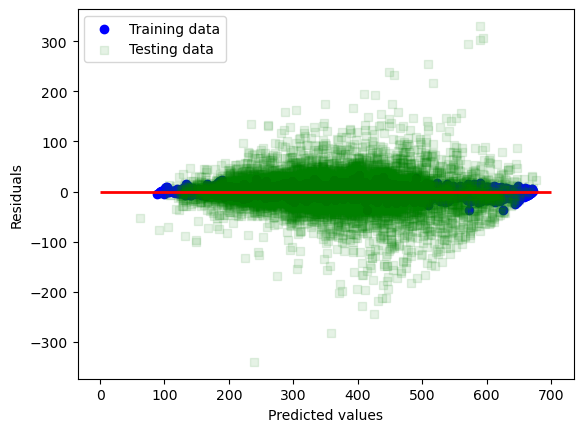

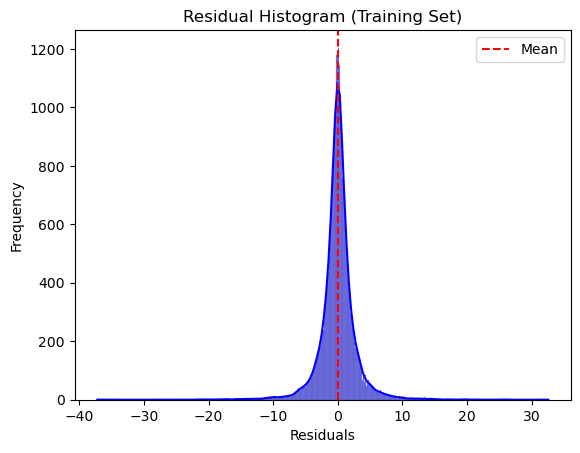

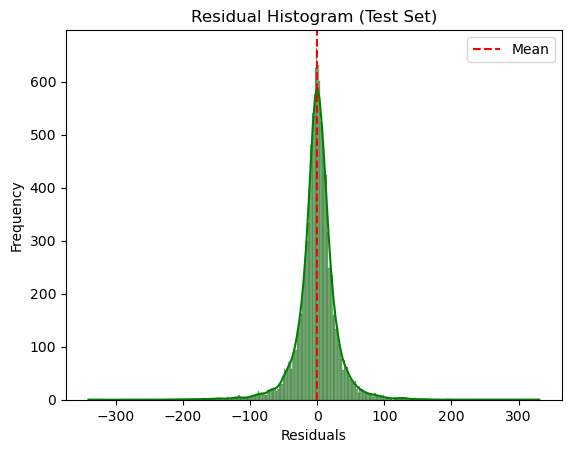

In [ ]:
residual_plot(XGB_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

#### Standartize continous columns

In [ ]:
X_train_expedia_standartize = X_train_expedia.copy()  
standartize_cols = ['Index', 'TTT', 'LOS', 'Grade', 'Num of Reviews']
X_train_expedia_standartize[standartize_cols] = standartize.fit_transform(X_train_expedia[standartize_cols])
X_test_expedia_standartize = X_test_expedia.copy() 
X_test_expedia_standartize[standartize_cols] = standartize.fit_transform(X_test_expedia[standartize_cols])

In [ ]:
XGB_Expedia_standartize = XGBRegressor(**best_params)

In [ ]:
XGB_Expedia_standartize.fit(X_train_expedia_standartize, y_train_expedia)

XGBRegressor(base_score=0.025, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=4, missing=nan,
             monotone_constraints=None, n_estimators=1100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
metrics_f(XGB_Expedia_standartize , X_train_expedia_standartize ,X_test_expedia_standartize, y_train_expedia ,y_test_expedia)

Train MSE: 8.098184681495832
Test MSE: 933.2790479264877
Train RMSE: 2.8457309573281577
Test RMSE: 30.54961616659836
Train MAE: 1.7355273456446014
Test MAE: 19.302567327250895
Train R2: 0.9992857043314801
Test R2: 0.9183322059558364


#### Add checkin columns

In [ ]:
expedia_df_prepeared_more_features = Checkin_day(expedia_df_prepeared)

<AxesSubplot:xlabel='Checkin Day of week'>

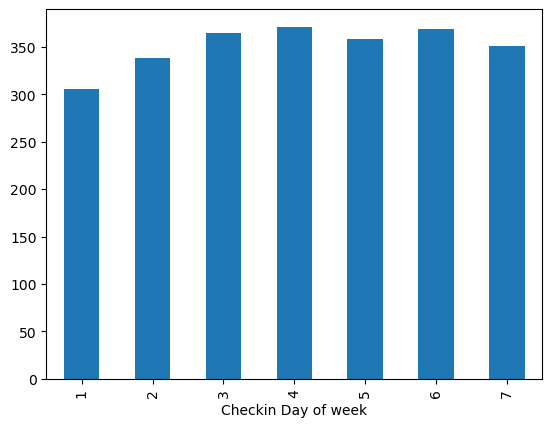

In [ ]:
expedia_df_prepeared_more_features.groupby('Checkin Day of week')['Curr Price'].mean().plot(kind='bar')

In [ ]:
X_train_expedia_more_features = Checkin_day(X_train_expedia)
X_test_expedia_more_features = Checkin_day(X_test_expedia)

In [ ]:
XGB_Expedia_more_features = XGBRegressor(**best_params)
XGB_Expedia_more_features.fit(X_train_expedia_more_features, y_train_expedia)
metrics_f(XGB_Expedia_more_features , X_train_expedia_more_features ,X_test_expedia_more_features, y_train_expedia ,y_test_expedia)

Train MSE: 3.5462915843761533
Test MSE: 860.4742525672967
Train RMSE: 1.883159999675055
Test RMSE: 29.333841421936146
Train MAE: 1.1251957615101988
Test MAE: 18.054643397220275
Train R2: 0.9996872014139395
Test R2: 0.9247030840399764


### Booking

In [ ]:
booking_df_prepeared.head()

Snapshot  Index                          Hotel Name  TTT  LOS  Grade  \
0   Monday      1  Margaritaville Resort Times Square    1    1    8.8   
1   Monday      2           33 Seaport Hotel New York    1    1    8.6   
2   Monday      3                 The Belvedere Hotel    1    1    8.0   
3   Monday      4                      CIVILIAN Hotel    1    1    8.5   
4   Monday      5     The Cloud One New York-Downtown    1    1    8.2   

   Num of Reviews  Curr Price  Original Price  Distance from center  \
0            1369      210.25          210.25                  1500   
1             284      293.57          293.57                  6900   
2            3644      142.59          142.59                   900   
3            1172      214.45          214.45                   900   
4             518      173.35          173.35                  7000   

              Type of room  Location grade  Free Cancellation  \
0      Standard Queen Room               1                  0   
1  Superior Courtyard King               0                  0   
2       Standard King Room               1                  0   
3              Double Room               1                  0   
4       Standard King Room               0                  1   

   No prepayment needed  Breakfast included  Cancel Later  Friday  Monday  \
0                     0                   0             0       0       1   
1                     0                   0             0       0       1   
2                     0                   0             0       0       1   
3                     0                   0             0       0       1   
4                     1                   0             1       0       1   

   Wednesday  Discount  
0          0         0  
1          0         0  
2          0         0  
3          0         0  
4          0         0

In [ ]:
columns_to_drop = ['Hotel Name', 'Original Price', 'Snapshot', 'Type of room']
X_train_booking = X_full_data_train_booking.drop(columns_to_drop, axis=1)
X_test_booking = X_full_data_test_booking.drop(columns_to_drop, axis=1)

#### Run Model

In [ ]:
XGB_Booking = xgb_hyperparameter(X_train_booking, y_train_booking)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[14:27:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[CV 1/5] END base_score=0.5, booster=gblinear, eta=0.2, max_depth=15, min_child_weight=3, n_estimators=900;, score=0.261 total time=   2.8s
[14:28:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[CV 2/5] END base_score=0.5, booster=gblinear, eta=0.2, max_depth=15, min_child_weight=3, n_estimators=900;, score=0.268 total time=   2.7s
[14:28:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.



In [ ]:
XGB_Booking.fit(X_train_booking, y_train_booking)
metrics_f(XGB_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

Train MSE: 11.21612523890388
Test MSE: 475.5926059727034
Train RMSE: 3.349048407966639
Test RMSE: 21.808085793409365
Train MAE: 2.3682700806636086
Test MAE: 15.12071295051693
Train R2: 0.9982212249700357
Test R2: 0.9243067506264921


In [ ]:
joblib.dump(XGB_Booking, "XGB_Booking.pkl")

['XGB_Booking.pkl']

#### Analyze Results

In [ ]:
XGB_Booking = joblib.load("XGB_Booking.pkl")

In [ ]:
best_params = XGB_Booking.get_params()

In [ ]:
best_params

{'objective': 'reg:squarederror',
 'base_score': 0.75,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 4,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 1500,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.05}

In [ ]:
metrics_f(XGB_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

Train MSE: 11.21612523890388
Test MSE: 475.5926059727034
Train RMSE: 3.349048407966639
Test RMSE: 21.808085793409365
Train MAE: 2.3682700806636086
Test MAE: 15.12071295051693
Train R2: 0.9982212249700357
Test R2: 0.9243067506264921


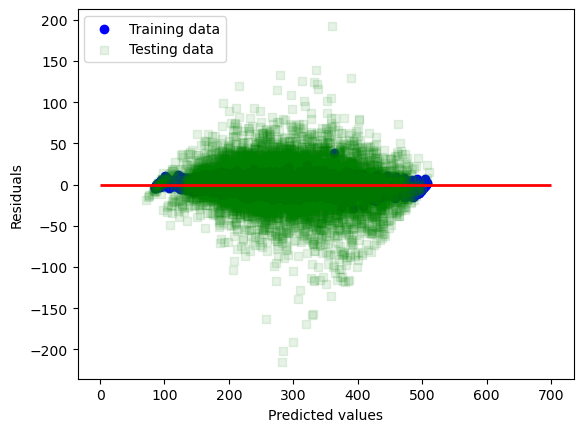

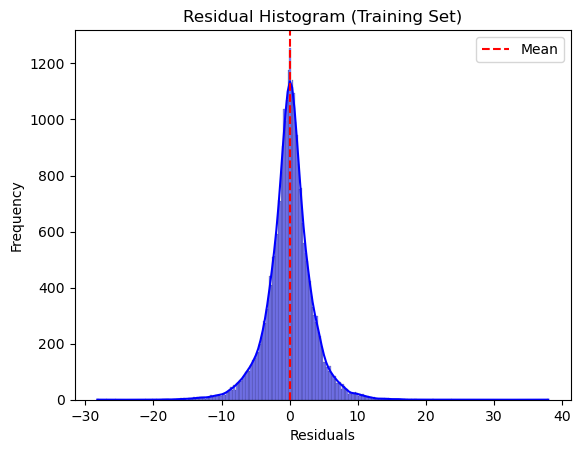

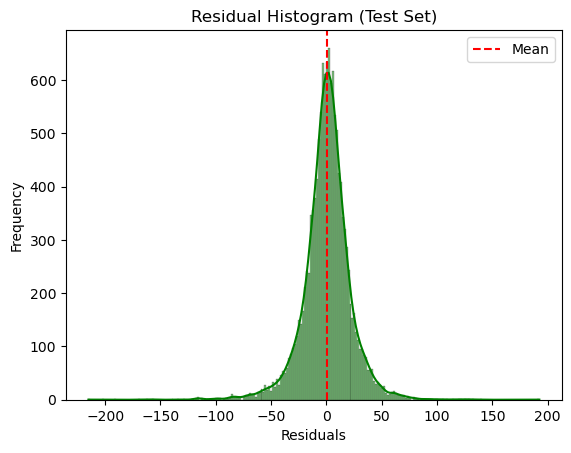

In [ ]:
residual_plot(XGB_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

#### Standartize continous columns

In [ ]:
X_train_booking_standartize = X_train_booking.copy()  
standartize_cols = ['Index', 'TTT', 'LOS', 'Grade', 'Num of Reviews','Distance from center']
X_train_booking_standartize[standartize_cols] = standartize.fit_transform(X_train_booking[standartize_cols])
X_test_booking_standartize = X_test_booking.copy() 
X_test_booking_standartize[standartize_cols] = standartize.fit_transform(X_test_booking[standartize_cols])

In [ ]:
XGB_Booking_standartize = XGBRegressor(**best_params)

In [ ]:
XGB_Booking_standartize.fit(X_train_booking_standartize, y_train_booking)

XGBRegressor(base_score=0.75, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=4, missing=nan,
             monotone_constraints=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [ ]:
metrics_f(XGB_Booking_standartize , X_train_booking_standartize ,X_test_booking_standartize, y_train_booking ,y_test_booking)

Train MSE: 11.21612523890388
Test MSE: 475.5383793162573
Train RMSE: 3.349048407966639
Test RMSE: 21.806842488454336
Train MAE: 2.3682700806636086
Test MAE: 15.122492183223327
Train R2: 0.9982212249700357
Test R2: 0.924315381105136


#### Add checkin columns

In [ ]:
booking_df_prepeared_more_features = Checkin_day(booking_df_prepeared)

<AxesSubplot:xlabel='Checkin Day of week'>

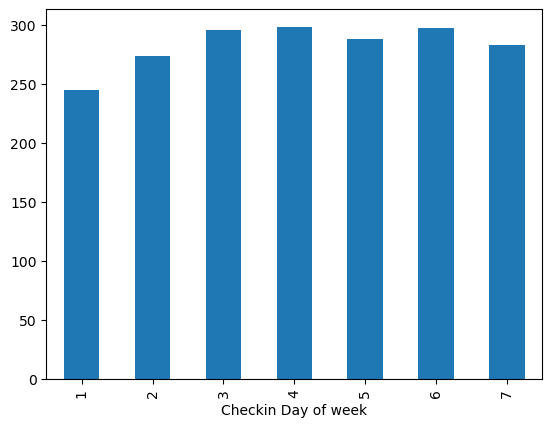

In [ ]:
booking_df_prepeared_more_features.groupby('Checkin Day of week')['Curr Price'].mean().plot(kind='bar')

In [ ]:
X_train_booking_more_features = Checkin_day(X_train_booking)
X_test_booking_more_features = Checkin_day(X_test_booking)

In [ ]:
XGB_Booking_more_features = XGBRegressor(**best_params)
XGB_Booking_more_features.fit(X_train_booking_more_features, y_train_booking)
metrics_f(XGB_Booking_more_features , X_train_booking_more_features ,X_test_booking_more_features, y_train_booking ,y_test_booking)

Train MSE: 6.549942413442766
Test MSE: 397.92056703050434
Train RMSE: 2.5592855279243008
Test RMSE: 19.94794643642559
Train MAE: 1.7843935925428658
Test MAE: 13.528318500815306
Train R2: 0.9989612389515478
Test R2: 0.9366686943135185


## ElasticNet

### Expedia

In [ ]:
columns_to_drop = ['Hotel Name', 'Original Price', 'Snapshot']
X_train_expedia = X_full_data_train_expedia.drop(columns_to_drop, axis=1)
X_test_expedia = X_full_data_test_expedia.drop(columns_to_drop, axis=1)

#### Run the model

In [ ]:
enet_Expedia = ElasticNet_hyperparameter(X_train_expedia, y_train_expedia)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.288 total time=   0.0s
[CV 2/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.274 total time=   0.0s
[CV 3/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.283 total time=   0.0s
[CV 4/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.273 total time=   0.0s
[CV 5/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.281 total time=   0.0s
[CV 1/5] END ...........alpha=0.1, l1_ratio=0.3;, score=0.291 total time=   0.0s
[CV 2/5] END ...........alpha=0.1, l1_ratio=0.3;, score=0.276 total time=   0.0s
[CV 3/5] END ...........alpha=0.1, l1_ratio=0.3;, score=0.285 total time=   0.0s
[CV 4/5] END ...........alpha=0.1, l1_ratio=0.3;, score=0.275 total time=   0.0s
[CV 5/5] END ...........alpha=0.1, l1_ratio=0.3;, score=0.283 total time=   0.0s
[CV 1/5] END ...........alpha=0.1, l1_ratio=0.5;, score=0.293 total time=   0.0s
[CV 2/5] END ...........alpha=0.1, l1_ratio=0.5

In [ ]:
enet_Expedia.fit(X_train_expedia, y_train_expedia)
metrics_f(enet_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

Train MSE: 8051.9323982079495
Test MSE: 8113.058730789979
Train RMSE: 89.73256041263923
Test RMSE: 90.0725192874607
Train MAE: 69.63662497268001
Test MAE: 70.05220015253595
Train R2: 0.28978398721914855
Test R2: 0.29005626884431146


In [ ]:
joblib.dump(enet_Expedia, "ENET_Expedia.pkl")

['ENET_Expedia.pkl']

#### Analyze Results

In [ ]:
enet_Expedia = joblib.load("ENET_Expedia.pkl")

In [ ]:
best_params = enet_Expedia.get_params()

In [ ]:
enet_Expedia.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.9,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [ ]:
metrics_f(enet_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

Train MSE: 8051.9323982079495
Test MSE: 8113.058730789979
Train RMSE: 89.73256041263923
Test RMSE: 90.0725192874607
Train MAE: 69.63662497268001
Test MAE: 70.05220015253595
Train R2: 0.28978398721914855
Test R2: 0.29005626884431146


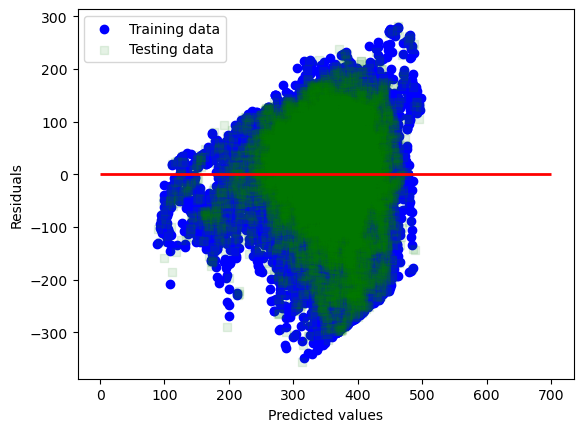

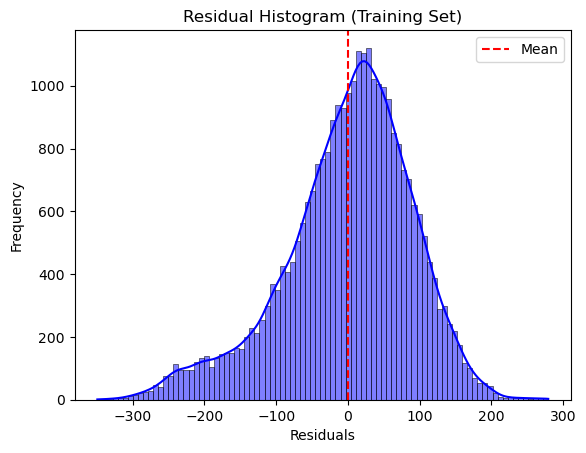

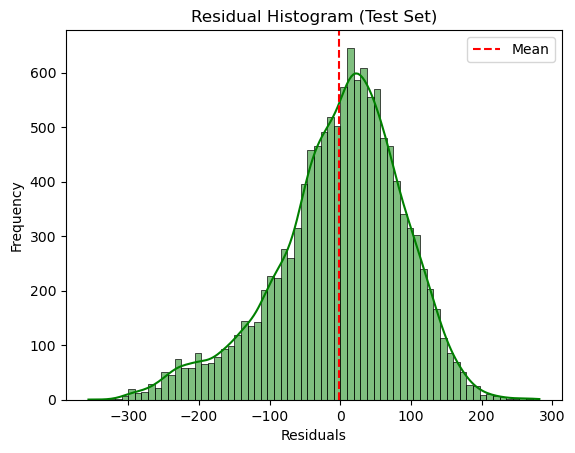

In [ ]:
residual_plot(enet_Expedia , X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

In [ ]:
col_to_square = hyper_feature( ElasticNet(**best_params) , X_train_expedia , y_train_expedia)

Feature_squared: Index, R-squared: 0.3088945392135275
Feature_squared: TTT, R-squared: 0.32049783722542524
Feature_squared: LOS, R-squared: 0.3079735434365216
Feature_squared: Grade, R-squared: 0.3160570930068256
Feature_squared: Num of Reviews, R-squared: 0.30891748724553303
Feature_squared: Is refundable, R-squared: 0.30872514812728524
Feature_squared: Late payment, R-squared: 0.3087251373821427
Feature_squared: Extras included, R-squared: 0.3087251526089404
Feature_squared: Option Member, R-squared: 0.30872513636324617
Feature_squared: Friday, R-squared: 0.3087251705595696
Feature_squared: Monday, R-squared: 0.3087251610582078
Feature_squared: Wednesday, R-squared: 0.30872523663125384
Feature_squared: Discount, R-squared: 0.3087251437188214
Best feature_squared: TTT, Best R-squared: 0.32049783722542524


In [ ]:
feature_squared_score( ElasticNet(**best_params) ,col_to_square, X_train_expedia ,X_test_expedia, y_train_expedia ,y_test_expedia)

0.3014404111377148


#### Standartize continous columns

In [ ]:
X_train_expedia_standartize = X_train_expedia.copy()  
standartize_cols = ['Index', 'TTT', 'LOS', 'Grade', 'Num of Reviews']
X_train_expedia_standartize[standartize_cols] = standartize.fit_transform(X_train_expedia[standartize_cols])
X_test_expedia_standartize = X_test_expedia.copy() 
X_test_expedia_standartize[standartize_cols] = standartize.fit_transform(X_test_expedia[standartize_cols])

In [ ]:
enet_Expedia_standartize = ElasticNet(**best_params)

In [ ]:
enet_Expedia_standartize.fit(X_train_expedia_standartize, y_train_expedia)

ElasticNet(alpha=0.1, l1_ratio=0.9)

In [ ]:
metrics_f(enet_Expedia_standartize , X_train_expedia_standartize ,X_test_expedia_standartize, y_train_expedia ,y_test_expedia)

Train MSE: 8050.810625763712
Test MSE: 8112.589162009995
Train RMSE: 89.72630955167894
Test RMSE: 90.06991263463063
Train MAE: 69.64430019535952
Test MAE: 70.01905536828677
Train R2: 0.28988293250497477
Test R2: 0.29009735906968237


#### Add checkin columns

In [ ]:
expedia_df_prepeared_more_features = Checkin_day(expedia_df_prepeared)

<AxesSubplot:xlabel='Checkin Day of week'>

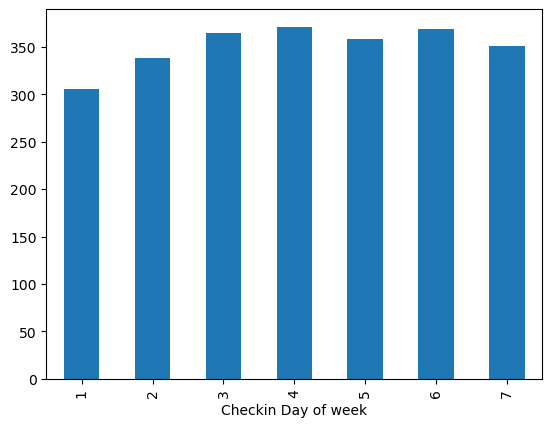

In [ ]:
expedia_df_prepeared_more_features.groupby('Checkin Day of week')['Curr Price'].mean().plot(kind='bar')

In [ ]:
X_train_expedia_more_features = Checkin_day(X_train_expedia)
X_test_expedia_more_features = Checkin_day(X_test_expedia)

In [ ]:
enet_Expedia_more_features = ElasticNet(**best_params)
enet_Expedia_more_features.fit(X_train_expedia_more_features, y_train_expedia)
metrics_f(enet_Expedia_more_features , X_train_expedia_more_features ,X_test_expedia_more_features, y_train_expedia ,y_test_expedia)

Train MSE: 7895.346193730333
Test MSE: 7937.016738822167
Train RMSE: 88.85576061083678
Test RMSE: 89.08993623761422
Train MAE: 68.98953953225508
Test MAE: 69.1957393694288
Train R2: 0.30359558228734995
Test R2: 0.3054610517708044


### Booking

In [ ]:
columns_to_drop = ['Hotel Name', 'Original Price', 'Snapshot', 'Type of room']
X_train_booking = X_full_data_train_booking.drop(columns_to_drop, axis=1)
X_test_booking = X_full_data_test_booking.drop(columns_to_drop, axis=1)

#### Run Model

In [ ]:
enet_Booking = ElasticNet_hyperparameter(X_train_booking, y_train_booking)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.277 total time=   0.0s
[CV 2/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.282 total time=   0.0s
[CV 3/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.285 total time=   0.0s
[CV 4/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.275 total time=   0.0s
[CV 5/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.284 total time=   0.0s
[CV 1/5] END ...........alpha=0.1, l1_ratio=0.3;, score=0.279 total time=   0.0s
[CV 2/5] END ...........alpha=0.1, l1_ratio=0.3;, score=0.284 total time=   0.0s
[CV 3/5] END ...........alpha=0.1, l1_ratio=0.3;, score=0.288 total time=   0.0s
[CV 4/5] END ...........alpha=0.1, l1_ratio=0.3;, score=0.277 total time=   0.0s
[CV 5/5] END ...........alpha=0.1, l1_ratio=0.3;, score=0.286 total time=   0.0s
[CV 1/5] END ...........alpha=0.1, l1_ratio=0.5;, score=0.281 total time=   0.0s
[CV 2/5] END ...........alpha=0.1, l1_ratio=0.5

In [ ]:
enet_Booking.fit(X_train_booking, y_train_booking)
metrics_f(enet_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

Train MSE: 4486.701320736294
Test MSE: 4458.675737050466
Train RMSE: 66.98284348052339
Test RMSE: 66.77331605552075
Train MAE: 52.751055711415695
Test MAE: 52.55707449606296
Train R2: 0.28845014599593644
Test R2: 0.290376573979915


In [ ]:
joblib.dump(enet_Booking, "ENET_Booking.pkl")

['ENET_Booking.pkl']

#### Analyze Results

In [ ]:
enet_Booking = joblib.load("ENET_Booking.pkl")

In [ ]:
best_params = enet_Booking.get_params()

In [ ]:
enet_Booking.get_params()

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.9,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [ ]:
metrics_f(enet_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

Train MSE: 4486.701320736294
Test MSE: 4458.675737050466
Train RMSE: 66.98284348052339
Test RMSE: 66.77331605552075
Train MAE: 52.751055711415695
Test MAE: 52.55707449606296
Train R2: 0.28845014599593644
Test R2: 0.290376573979915


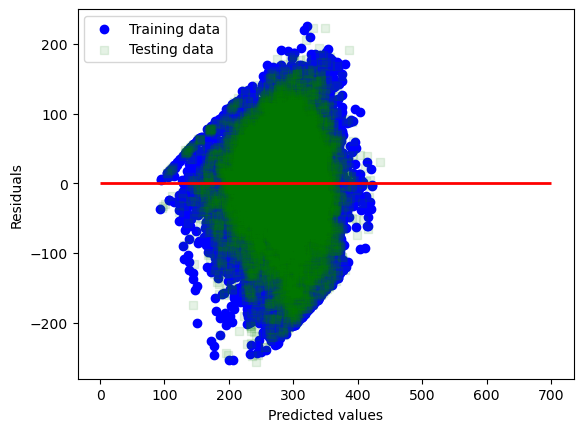

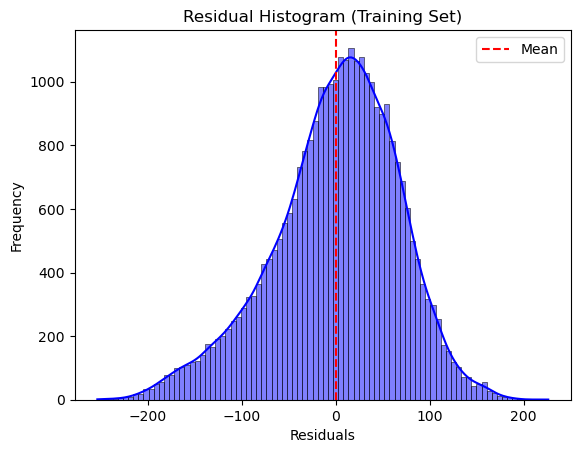

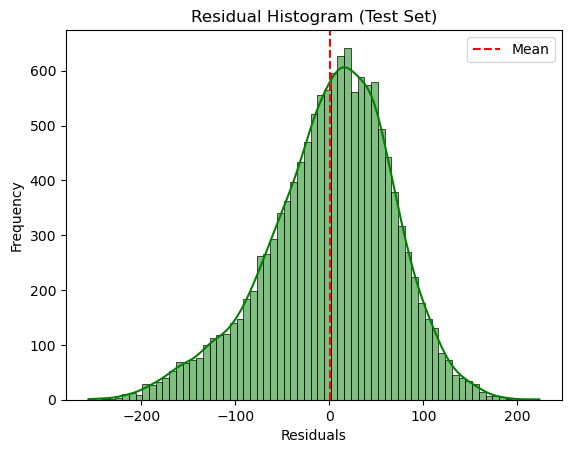

In [ ]:
residual_plot(enet_Booking , X_train_booking ,X_test_booking, y_train_booking ,y_test_booking)

In [ ]:
col_to_square = hyper_feature( ElasticNet(**best_params) , X_train_booking , y_train_booking)

Feature_squared: Index, R-squared: 0.28185642707868663
Feature_squared: TTT, R-squared: 0.3010737005077223
Feature_squared: LOS, R-squared: 0.28603045854779097
Feature_squared: Grade, R-squared: 0.2885738673071857
Feature_squared: Num of Reviews, R-squared: 0.2810776013614332
Feature_squared: Distance from center, R-squared: 0.2793912257121989
Feature_squared: Location grade, R-squared: 0.2861033848846225
Feature_squared: Free Cancellation, R-squared: 0.2861028112086791
Feature_squared: No prepayment needed, R-squared: 0.28610281771058543
Feature_squared: Breakfast included, R-squared: 0.28610337660425034
Feature_squared: Cancel Later, R-squared: 0.28610333194323523
Feature_squared: Friday, R-squared: 0.28610337880452463
Feature_squared: Monday, R-squared: 0.2861033815896058
Feature_squared: Wednesday, R-squared: 0.28610338021783
Feature_squared: Discount, R-squared: 0.2861033800909616
Best feature_squared: TTT, Best R-squared: 0.3010737005077223


In [ ]:
feature_squared_score( ElasticNet(**best_params) ,col_to_square, X_train_booking,X_test_booking, y_train_booking ,y_test_booking)

0.30648177318215364


#### Standartize continous columns

In [ ]:
X_train_booking_standartize = X_train_booking.copy()  
standartize_cols = ['Index', 'TTT', 'LOS', 'Grade', 'Num of Reviews','Distance from center']
X_train_booking_standartize[standartize_cols] = standartize.fit_transform(X_train_booking[standartize_cols])
X_test_booking_standartize = X_test_booking.copy() 
X_test_booking_standartize[standartize_cols] = standartize.fit_transform(X_test_booking[standartize_cols])

In [ ]:
enet_Booking_standartize = ElasticNet(**best_params)

In [ ]:
enet_Booking_standartize.fit(X_train_booking_standartize, y_train_booking)

ElasticNet(alpha=0.1, l1_ratio=0.9)

In [ ]:
metrics_f(enet_Booking_standartize , X_train_booking_standartize ,X_test_booking_standartize, y_train_booking ,y_test_booking)

Train MSE: 4486.228113168547
Test MSE: 4457.605997576059
Train RMSE: 66.97931108311391
Test RMSE: 66.7653053432399
Train MAE: 52.75343729599856
Test MAE: 52.5450767281335
Train R2: 0.288525192394543
Test R2: 0.29054682905912377


#### Add checkin columns

In [ ]:
booking_df_prepeared_more_features = Checkin_day(booking_df_prepeared)

<AxesSubplot:xlabel='Checkin Day of week'>

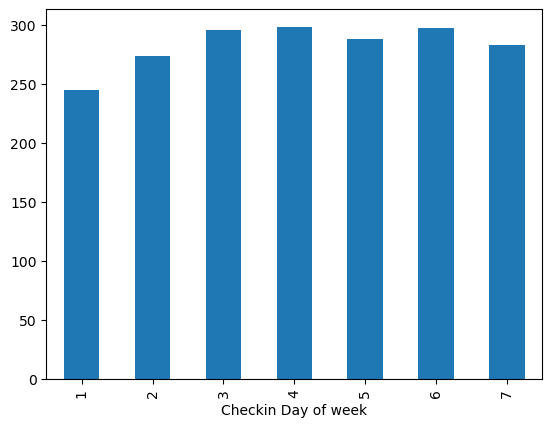

In [ ]:
booking_df_prepeared_more_features.groupby('Checkin Day of week')['Curr Price'].mean().plot(kind='bar')

In [ ]:
X_train_booking_more_features = Checkin_day(X_train_booking)
X_test_booking_more_features = Checkin_day(X_test_booking)

In [ ]:
enet_Booking_more_features = ElasticNet(**best_params)
enet_Booking_more_features.fit(X_train_booking_more_features, y_train_booking)
metrics_f(enet_Booking_more_features , X_train_booking_more_features ,X_test_booking_more_features, y_train_booking ,y_test_booking)

Train MSE: 4370.577648495757
Test MSE: 4328.295486870537
Train RMSE: 66.1103444893139
Test RMSE: 65.78978254159637
Train MAE: 52.265162126659085
Test MAE: 51.98380782732721
Train R2: 0.30686629989664016
Test R2: 0.31112732717984193


# Predicting the difference between Prices

In [ ]:
len(booking_df_prepeared.groupby('Hotel Name'))

374

In [ ]:
len(expedia_df_prepeared.groupby('Hotel Name'))

386

In [ ]:
from fuzzywuzzy import fuzz

def fuzzy_match(x, choices):
    return choices.apply(lambda y: fuzz.partial_ratio(x, y)).idxmax()

booking_df_prepeared['matched_hotel'] = booking_df_prepeared['Hotel Name'].apply(fuzzy_match, choices=expedia_df_prepeared['Hotel Name'])